In [1]:
# pip install tensorflow --upgrade

In [2]:
# pip install pycaret

In [107]:
import pandas as pd
import numpy as np
import glob
import os
import lxml
import math
from pycaret.regression import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import History

In [4]:
def personnality_translator(personnality):
    if personnality == "Citoyen modèle":
        return 16, 18, 17, 18, 18, 18
    elif personnality == "Perfectionniste":
        return 17, 11, 11, 17, 11, 5
    elif personnality == "Ambitieux":
        return 18, 8, 11, 11, 11, 11
    elif personnality == "Assez ambitieux":
        return 18, 11, 11, 8, 11, 11
    elif personnality == "Assez déterminé":
        return 11, 11, 11, 8, 13, 11
    elif personnality == "Assez fair-play":
        return 8, 8, 11, 8, 18, 5
    elif personnality == "Assez loyal":
        return 11, 18, 11, 8, 11, 11
    elif personnality == "Assez professionnel":
        return 11, 11, 11, 18, 11, 11
    elif personnality == "Décontracté":
        return 11, 11, 11, 3, 11, 13
    elif personnality == "Déloyal":
        return 11, 11, 11, 11, 1, 11
    elif personnality == "Déterminé":
        return 13, 10, 9, 18, 13, 11
    elif personnality == "Dévoué":
        return 7, 20, 11, 11, 11, 11
    elif personnality == "Effronté":
        return 11, 11, 20, 11, 13, 11
    elif personnality == "Enjoué":
        return 11, 11, 18, 14, 8, 15
    elif personnality == "Équilibré":
        return 8, 8, 11, 8, 8, 8
    elif personnality == "Facilement découragé":
        return 5, 11, 11, 13, 9, 11
    elif personnality == "Faible détermination":
        return 5, 11, 11, 13, 9, 11
    elif personnality == "Faible confiance en soi":
        return 11, 11, 3, 13, 9, 11
    elif personnality == "Fair-play":
        return 11, 11, 11, 13, 19, 11
    elif personnality == "Forte personnalité":
        return 11, 11, 11, 6, 11, 3
    elif personnality == "Friable":
        return 11, 11, 1, 13, 9, 11
    elif personnality == "Honnête":
        return 11, 11, 11, 13, 20, 11
    elif personnality == "Indolent":
        return 11, 11, 11, 1, 11, 13
    elif personnality == "Jovial":
        return 11, 11, 18, 6, 8, 15
    elif personnality == "Leader":
        return 11, 11, 11, 11, 11, 11
    elif personnality == "Leader charismatique":
        return 11, 11, 11, 11, 19, 19
    elif personnality == "Leader né":
        return 11, 11, 11, 11, 11, 11
    elif personnality == "Loyal":
        return 7, 19, 11, 11, 11, 11
    elif personnality == "Mercenaire":
        return 18, 2, 11, 11, 11, 11
    elif personnality == "Modèle de professionnalisme":
        return 11, 11, 11, 20, 11, 15
    elif personnality == "Motivé":
        return 16, 11, 11, 11, 11, 11
    elif personnality == "Obstiné":
        return 6, 11, 11, 11, 11, 11
    elif personnality == "Professionnel":
        return 11, 11, 11, 19, 11, 15
    elif personnality == "Réaliste":
        return 11, 11, 11, 11, 3, 11
    elif personnality == "Résistant":
        return 13, 11, 18, 11, 13, 11
    elif personnality == "Sans ambition":
        return 3, 11, 11, 11, 11, 16
    elif personnality == "Très ambitieux":
        return 20, 8, 11, 11, 11, 11
    elif personnality == "Très loyal":
        return 7, 20, 11, 11, 11, 11
    elif personnality == "Versatile":
        return 18, 5, 11, 11, 11, 11
    else:
        return 11, 11, 11, 11, 11, 11
        

In [5]:
division_db = pd.read_html("FM_division_db.html", header=0, encoding="utf-8", keep_default_na=False)[0]
division_db["ranking"] = division_db.index
division_db["nom_div"] = division_db["Nom"]
division_db = division_db.drop("Nom", axis=1)

conditions = [
    (division_db['ranking'] == 0),
    (division_db['ranking'] > 0) & (division_db['ranking'] <= 4),
    (division_db['ranking'] > 4) & (division_db['ranking'] <= 12),
    (division_db['ranking'] > 12) & (division_db['ranking'] <= 36),
    (division_db['ranking'] > 36) & (division_db['ranking'] <= 74),
    (division_db['ranking'] > 74) & (division_db['ranking'] <= 131),
    (division_db['ranking'] > 131) & (division_db['ranking'] <= 210),
    (division_db['ranking'] > 210) & (division_db['ranking'] <= 330),
    (division_db['ranking'] > 330)
    ]

values = [18, 16, 14, 12, 10, 8, 6, 4, 2]

division_db['reputation'] = np.select(conditions, values)

In [6]:
division_db.head(3)

,Pays,Réputation,ranking,nom_div,reputation
0,Angleterre,,0,Première Division anglaise,18
1,Espagne,,1,Première Division d'Espagne,16
2,Italie,,2,Serie A,16


In [7]:
wrong_divisions = {
    "Vanarama National League North" : "Vanarama National League North/South",
    "Vanarama National League South" : "Vanarama National League North/South",
    "Division Régionale Allemande Ouest" : "Championnat régional allemand",
    "Division Régionale Sud Allemande" : "Championnat régional allemand",
    "Division Régionale Nord Allemande" : "Championnat régional allemand",
    "Div. allemande du Rhin moyen" : "Division inférieure d'Allemagne",
    "Div. allemande du Rhin bas" : "Division inférieure d'Allemagne",
    "Première Division A de la Fédération espagnole" : "Première Division de la Fédération espagnole",
    "Première Division B de la Fédération espagnole" : "Première Division de la Fédération espagnole",
                  }

In [8]:
training_0 = pd.read_html("Training_0.html", header=0, encoding="utf-8", keep_default_na=False)[0]
training_1 = pd.read_html("Training_1.html", header=0, encoding="utf-8", keep_default_na=False)[0]
training_2 = pd.read_html("Training_2.html", header=0, encoding="utf-8", keep_default_na=False)[0]
training_3 = pd.read_html("Training_3.html", header=0, encoding="utf-8", keep_default_na=False)[0]
training_4 = pd.read_html("Training_4.html", header=0, encoding="utf-8", keep_default_na=False)[0]
training_5 = pd.read_html("Training_5.html", header=0, encoding="utf-8", keep_default_na=False)[0]
training_6 = pd.read_html("Training_6.html", header=0, encoding="utf-8", keep_default_na=False)[0]
training_7 = pd.read_html("Training_7.html", header=0, encoding="utf-8", keep_default_na=False)[0]
training_8 = pd.read_html("Training_8.html", header=0, encoding="utf-8", keep_default_na=False)[0]
training_9 = pd.read_html("Training_9.html", header=0, encoding="utf-8", keep_default_na=False)[0]
final_training_db = pd.concat([training_0, training_1, training_2, training_3, training_4, training_5,\
                               training_6, training_7, training_8, training_9])
final_training_db = final_training_db.replace({"Division": wrong_divisions})
final_training_db.loc[final_training_db['Division'].str.contains('2ème Division de la Fédération espagnole'), 'Division'] = 'Deuxième Division de la Fédération espagnole'
final_training_db.loc[final_training_db['Division'].str.contains('3ème Division de la Fédération espagnole'), 'Division'] = '3ème Division de la Fédération espagnole'
final_training_db.loc[final_training_db['Division'].str.contains('Série C'), 'Division'] = 'Série C italienne'
final_training_db.loc[final_training_db['Division'].str.contains('Série D'), 'Division'] = 'Série D italienne'
final_training_db.loc[final_training_db['Division'].str.contains('National 2'), 'Division'] = 'National 2'
final_training_db.loc[final_training_db['Division'].str.contains('National 3'), 'Division'] = 'National 3 français'
final_training_db.loc[final_training_db['Division'].str.contains('Division Régionale Allemande'), 'Division'] = 'Championnat régional allemand'
final_training_db.loc[final_training_db['Division'].str.contains('Division régionale allemande'), 'Division'] = 'Championnat régional allemand'
final_training_db.loc[final_training_db['Division'].str.contains('Troisième division du Portugal'), 'Division'] = 'Troisième division portugaise'
final_training_db.loc[final_training_db['Division'].str.contains('Championnat National Portugais'), 'Division'] = 'Championnat National Portugais'
final_training_db = final_training_db.merge(division_db, left_on="Division", right_on="nom_div", how="left").drop(["nom_div", "Pays", "Réputation", "Division"], axis=1)
final_training_db = final_training_db[final_training_db.ranking.notna()]
final_training_db = final_training_db.reset_index(drop=True)

In [9]:
# raw_db = pd.read_html("FM_complete_db_players.html", header=0, encoding="utf-8", keep_default_na=False)[0]
# raw_db = raw_db.replace({"Division": wrong_divisions})
# raw_db.loc[raw_db['Division'].str.contains('2ème Division de la Fédération espagnole'), 'Division'] = 'Deuxième Division de la Fédération espagnole'
# raw_db.loc[raw_db['Division'].str.contains('3ème Division de la Fédération espagnole'), 'Division'] = '3ème Division de la Fédération espagnole'
# raw_db.loc[raw_db['Division'].str.contains('Série C'), 'Division'] = 'Série C italienne'
# raw_db.loc[raw_db['Division'].str.contains('Série D'), 'Division'] = 'Série D italienne'
# raw_db.loc[raw_db['Division'].str.contains('National 2'), 'Division'] = 'National 2'
# raw_db.loc[raw_db['Division'].str.contains('National 3'), 'Division'] = 'National 3 français'
# raw_db.loc[raw_db['Division'].str.contains('Division Régionale Allemande'), 'Division'] = 'Championnat régional allemand'
# raw_db.loc[raw_db['Division'].str.contains('Division régionale allemande'), 'Division'] = 'Championnat régional allemand'
# raw_db.loc[raw_db['Division'].str.contains('Troisième division du Portugal'), 'Division'] = 'Troisième division portugaise'
# raw_db.loc[raw_db['Division'].str.contains('Championnat National Portugais'), 'Division'] = 'Championnat National Portugais'
# raw_db = raw_db.merge(division_db, left_on="Division", right_on="nom_div", how="left").drop(["nom_div", "Pays", "Réputation", "Division"], axis=1)
# raw_db = raw_db[raw_db.ranking.notna()]


In [10]:
conditions_foot_g = [
    (final_training_db['Pied gauche'] == "Très faible"),
    (final_training_db['Pied gauche'] == "Faible"),
    (final_training_db['Pied gauche'] == "Acceptable"),
    (final_training_db['Pied gauche'] == "Assez fort"),
    (final_training_db['Pied gauche'] == "Fort"),
    (final_training_db['Pied gauche'] == "Très fort")
    ]

conditions_foot_d = [
    (final_training_db['Pied droit'] == "Très faible"),
    (final_training_db['Pied droit'] == "Faible"),
    (final_training_db['Pied droit'] == "Acceptable"),
    (final_training_db['Pied droit'] == "Assez fort"),
    (final_training_db['Pied droit'] == "Fort"),
    (final_training_db['Pied droit'] == "Très fort")
    ]

values_foot = [0, 4, 8, 12, 16, 20]

final_training_db['Pied gauche'] = np.select(conditions_foot_g, values_foot)
final_training_db['Pied droit'] = np.select(conditions_foot_d, values_foot)
final_training_db['Ambition'], final_training_db['Fidélité'], final_training_db['Pression'], final_training_db['Professionnalisme'], final_training_db['Fair-play'], final_training_db['Tempérament'] = zip(*final_training_db['Personnalité'].map(personnality_translator))
final_training_db["Blq/90"] = final_training_db["Blq/90"].replace("-", "0")
final_training_db["Blq/90"] = final_training_db["Blq/90"].astype('float32')
final_training_db["Buts/90"] = final_training_db["Buts/90"].replace("-", "0")
final_training_db["Buts/90"] = final_training_db["Buts/90"].astype('float32')
final_training_db["Ct réu/90"] = final_training_db["Ct réu/90"].replace("-", "0")
final_training_db["Ct réu/90"] = final_training_db["Ct réu/90"].astype('float32')
final_training_db["Déc/90"] = final_training_db["Déc/90"].replace("-", "0")
final_training_db["Déc/90"] = final_training_db["Déc/90"].astype('float32')
final_training_db["Drb/90"] = final_training_db["Drb/90"].replace("-", "0")
final_training_db["Drb/90"] = final_training_db["Drb/90"].astype('float32')
final_training_db["Int/90"] = final_training_db["Int/90"].replace("-", "0")
final_training_db["Int/90"] = final_training_db["Int/90"].astype('float32')
final_training_db["Pts/mat"] = final_training_db["Pts/mat"].replace("-", "0")
final_training_db["Pts/mat"] = final_training_db["Pts/mat"].astype('float32')
final_training_db["Mins/mat"] = final_training_db["Mins/mat"].replace("-", "0")
final_training_db["Mins/mat"] = final_training_db["Mins/mat"].astype('float32')
final_training_db["HdM"] = final_training_db["HdM"].replace("-", "0")
final_training_db["HdM"] = final_training_db["HdM"].astype('float32')
final_training_db["FC"] = final_training_db["FC"].replace("-", "0")
final_training_db["FC"] = final_training_db["FC"].astype('float32')
final_training_db["FS"] = final_training_db["FS"].replace("-", "0")
final_training_db["FS"] = final_training_db["FS"].astype('float32')
final_training_db["Jaune"] = final_training_db["Jaune"].replace("-", "0")
final_training_db["Jaune"] = final_training_db["Jaune"].astype('float32')
final_training_db["Rou"] = final_training_db["Rou"].replace("-", "0")
final_training_db["Rou"] = final_training_db["Rou"].astype('float32')
final_training_db["PCl/90"] = final_training_db["PCl/90"].replace("-", "0")
final_training_db["PCl/90"] = final_training_db["PCl/90"].astype('float32')
final_training_db["Ps R/90"] = final_training_db["Ps R/90"].replace("-", "0")
final_training_db["Ps R/90"] = final_training_db["Ps R/90"].astype('float32')
final_training_db["Pres. e"] = final_training_db["Pres. e"].replace("-", "0")
final_training_db["Pres. e"] = final_training_db["Pres. e"].astype('float32')
final_training_db["Poss remp/90"] = final_training_db["Poss remp/90"].replace("-", "0")
final_training_db["Poss remp/90"] = final_training_db["Poss remp/90"].astype('float32')
final_training_db["Poss perd/90"] = final_training_db["Poss perd/90"].replace("-", "0")
final_training_db["Poss perd/90"] = final_training_db["Poss perd/90"].astype('float32')
final_training_db["Têtes r/90"] = final_training_db["Têtes r/90"].replace("-", "0")
final_training_db["Têtes r/90"] = final_training_db["Têtes r/90"].astype('float32')
final_training_db["Tcl/90"] = final_training_db["Tcl/90"].replace("-", "0")
final_training_db["Tcl/90"] = final_training_db["Tcl/90"].astype('float32')
final_training_db["Note moy"] = final_training_db["Note moy"].replace("-", 0)
final_training_db["Note moy"] = final_training_db["Note moy"].astype('float32')

final_training_db = final_training_db[final_training_db["Mins/mat"] > 3000]
final_training_db = final_training_db.fillna(0)

In [11]:
final_training_db.shape

(218174, 101)

In [12]:
club_db = final_training_db[["Club", "Pts/mat"]].groupby('Club').mean().reset_index()
club_db["pts_club"] = club_db["Pts/mat"]/100
club_db.drop("Pts/mat", axis=1, inplace=True)
final_training_db = final_training_db.merge(club_db, on="Club")
final_training_db["Pts/mat"] = final_training_db["Pts/mat"]/100

In [540]:
dict_caracs = {
    "Pied gauche" : "Left foot",
    "Pied droit" : "Right foot",
    "Acc" : "Acceleration",
    "Vol" : "Work rate",
    "Vit" : "Pace",
    "Vis" : "Vision",
    "T Lg" : "Long throws",
    "Tir" : "Long shots",
    "Tec": "Technique",
    "Tcl" : "Tackling",
    "Phy" : "Natural fitness",
    "Pui" : "Strength",
    "Pla" : "Positioning", 
    "Pen" : "Penalty taking", 
    "Pas" : "Passing", 
    "Mar" : "Marking",
    "Ldr" : "Leadership",
    "Têt" : "Heading",
    "Col" : "Teamwork",
    "Ins" : "Flair",
    "Fin" : "Finishing",
    "Équ" : "Balance",
    "End" : "Stamina",
    "Drb" : "Dribbling",
    "Dét" : "Determination",
    "Dét.1" : "Jumping reach",
    "Déc" : "Decisions",
    "Crg" : "Bravery",
    "CF" : "Free kick taking",
    "Cor" : "Corners",
    "Ctr" : "First touch",
    "Ctn" : "Concentration",
    "Cen" : "Crossing",
    "Apl" : "Off the ball",
    "Ant" : "Anticipation",
    "Agr" : "Aggression",
    "Agi" : "Agility",
    "Ambition" : "Ambition",
    "Fidélité" : "Loyalty",
    "Pression" : "Important matches",
    "Professionnalisme" : "Professionalism",
    "Fair-play" : "Sportsmanship",
    "Tempérament" : "Temperament",
    "Sgf": "Composure"
}

In [665]:
final_training_db.shape

(218174, 102)

In [663]:
final_training_db.head()

,Drb/90,xG-HP/90,xG/90,Occ. / 90 min.,PCl/90,Poss perd/90,Poss remp/90,Têtes r/90,Tcl D/90,Tcl/90,FC,Min.,Rec,Sta,Nom,Poste,Taille,Personnalité,Âge,Salaire,Left foot,Right foot,Acceleration,Work rate,Pace,Vision,1c1,Long throws,Long shots,Technique,Tackling,TSP,Srf,Composure,Rel,Réf,Natural fitness,Strength,Pbl,Positioning,Penalty taking,Passing,Marking,Leadership,Heading,Teamwork,Flair,Finishing,Exc,Balance,Stamina,Dribbling,Determination,Jumping reach,Dét.2,Dég,Box,Decisions,Bravery,Free kick taking,Corners,First touch,Concentration,Com,Crossing,Off the ball,Anticipation,Aggression,Agility,Note moy,Mins/mat,FS,Int/90,enc/90,Buts/90,Cage(s) inviolée(s),Rou,Jaune,Ct Ten/90,Ct réu/90,Cln/90,Ps T/90,Ps R/90,Passes pr./90,Déc/90,xG,HdM,Club,Blq/90,Nouvelle caractéristique,Pres. e,% Ra,Pts/mat,ranking,reputation,Ambition,Loyalty,Important matches,Professionalism,Sportsmanship,Temperament,pts_club
0,111.0,018,018,050,288.0,406.0,1345.0,261.0,000,314.0,35.0,4 525,- - -,Int,Kevin De Bruyne,M/MO (C),181 cm,Professionnel,31,1 709 000 € p/m,16,20,14,14,14,19,2,6,16,17,8,3,3,15,2,2,16,13,2,11,15,18,8,13,5,13,16,15,1,14,16,14,17,9,1,3,3,17,13,16,13,15,14,2,19,13,14,12,12,7.38,8080.0,44.0,326.0,-,18.0,-,0.0,2.0,380,74.0,-,6359,5380.0,573,32.0,917,5.0,Man City,70.0,Aucune,802.0,-,2.07,0.0,18.0,11,11,11,19,11,15,2.228242
1,119.0,054,054,034,161.0,601.0,287.0,554.0,000,200.0,46.0,4 013,- - -,Int,Erling Haaland,BT (C),195 cm,Motivé,22,1 709 000 € p/m,20,8,17,13,19,14,2,5,13,15,7,1,2,19,2,1,19,17,1,8,17,14,7,13,16,13,16,18,1,18,15,15,20,18,3,4,3,14,15,14,8,16,16,1,11,18,18,13,16,7.50,7166.0,137.0,146.0,-,67.0,-,0.0,4.0,110,45.0,-,3604,2933.0,126,9.0,2395,7.0,Man City,34.0,Aucune,565.0,-,2.07,0.0,18.0,16,11,11,11,11,11,2.228242
2,47.0,008,008,018,67.0,432.0,1453.0,405.0,007,387.0,60.0,4 001,- - -,Int,Rodri,MD,191 cm,Professionnel,26,804 000 € p/m,12,20,14,16,13,14,2,8,14,14,17,2,2,17,1,3,16,16,3,17,8,15,12,11,13,16,9,9,2,12,17,13,13,17,3,4,2,18,15,8,7,15,16,1,8,13,18,13,13,7.08,7275.0,33.0,292.0,-,9.0,-,1.0,9.0,034,16.0,-,7108,6253.0,607,9.0,342,2.0,Man City,65.0,Aucune,814.0,-,2.05,0.0,18.0,11,11,11,19,11,15,2.228242
3,280.0,032,034,059,193.0,1212.0,692.0,311.0,000,317.0,53.0,4 433,- - -,Int,Bernardo Silva,"M (C), MO (DC)",173 cm,Perfectionniste,28,1 054 000 € p/m,20,4,15,20,14,17,1,2,13,18,8,2,2,17,1,3,17,9,2,13,13,17,12,12,10,16,17,15,2,16,17,17,16,7,3,3,2,15,15,14,14,17,15,1,15,17,16,13,19,7.64,7916.0,49.0,274.0,-,47.0,-,0.0,5.0,445,87.0,-,4600,3663.0,335,26.0,1669,9.0,Man City,45.0,Aucune,745.0,-,2.12,0.0,18.0,17,11,11,17,11,5,2.228242
4,5.0,002,002,014,16.0,173.0,1827.0,1106.0,025,127.0,47.0,3 897,- - -,Bls,Rúben Dias,D (C),186 cm,Professionnel,26,1 580 000 € p/m,12,20,13,17,13,13,3,5,4,13,18,2,1,15,1,1,18,16,2,17,8,14,17,17,15,16,8,6,1,12,18,12,18,16,3,1,4,15,17,5,4,13,16,2,11,8,17,16,13,7.26,8660.0,12.0,411.0,-,5.0,-,1.0,8.0,018,12.0,-,6185,5665.0,330,9.0,98,1.0,Man City,67.0,Aucune,284.0,-,1.96,0.0,18.0,11,11,11,19,11,15,2.228242


In [544]:
final_training_db = final_training_db.rename(columns=dict_caracs)

In [545]:
gk_db = final_training_db[final_training_db.Poste.str.contains("GB")]
field_db = final_training_db[final_training_db.Poste != "GB"]
dc_db = final_training_db[final_training_db.Poste.str.contains("D \(C") | final_training_db.Poste.str.contains("D \(DC") | final_training_db.Poste.str.contains("D \(DGC")]
dg_db = final_training_db[final_training_db.Poste.str.contains("D \(G") | final_training_db.Poste.str.contains("AL \(G") | final_training_db.Poste.str.contains("D \(DG") | final_training_db.Poste.str.contains("AL \(DG")]
dd_db = final_training_db[final_training_db.Poste.str.contains("D \(D") | final_training_db.Poste.str.contains("AL \(D")]
mdef_db = final_training_db[final_training_db.Poste.str.contains("MD")]
mc_db = final_training_db[final_training_db.Poste.str.contains("M \(GC") | final_training_db.Poste.str.contains("M \(C") | final_training_db.Poste.str.contains("M \(DC") | final_training_db.Poste.str.contains("M \(DGC")]
mo_db = final_training_db[final_training_db.Poste.str.contains("MO \(GC") | final_training_db.Poste.str.contains("MO \(C") | final_training_db.Poste.str.contains("MO \(DC") | final_training_db.Poste.str.contains("MO \(DGC")]
mg_db = final_training_db[final_training_db.Poste.str.contains("MO \(G") | final_training_db.Poste.str.contains("M \(G") | final_training_db.Poste.str.contains("MO \(DG") | final_training_db.Poste.str.contains("M \(DG")]
md_db = final_training_db[final_training_db.Poste.str.contains("MO \(D") | final_training_db.Poste.str.contains("M \(D")]
st_db = final_training_db[final_training_db.Poste.str.contains("BT \(C")]

In [546]:
field_att = ['Acc', 'Vol', 'Vit', 'Vis', 'T Lg', 'Tir', 'Tec', 'Tcl', 'Sgf', 
       'Phy', 'Pui', 'Pla', 'Pen', 'Pas', 'Mar', 'Ldr', 'Têt',
       'Col', 'Ins', 'Fin', 'Équ', 'End', 'Drb', 'Dét', 'Dét.1',
       'Déc', 'Crg', 'CF', 'Cor', 'Ctr', 'Ctn', 'Cen', 'Apl', 'Ant', 'Agr', 'Agi']

field_att = [dict_caracs[x] for x in field_att]

other_att = ['Ambition', 'Pression', 'Professionnalisme', 'Fidélité', 'Fair-play', 'Tempérament', 'Pied gauche', 'Pied droit']

other_att = [dict_caracs[x] for x in other_att]

In [543]:
test_db = pd.read_html("FM_complete_db_players.html", header=0, encoding="utf-8")[0]

In [547]:
conditions_foot_g = [
    (test_db['Pied gauche'] == "Très faible"),
    (test_db['Pied gauche'] == "Faible"),
    (test_db['Pied gauche'] == "Acceptable"),
    (test_db['Pied gauche'] == "Assez fort"),
    (test_db['Pied gauche'] == "Fort"),
    (test_db['Pied gauche'] == "Très fort")
    ]

conditions_foot_d = [
    (test_db['Pied droit'] == "Très faible"),
    (test_db['Pied droit'] == "Faible"),
    (test_db['Pied droit'] == "Acceptable"),
    (test_db['Pied droit'] == "Assez fort"),
    (test_db['Pied droit'] == "Fort"),
    (test_db['Pied droit'] == "Très fort")
    ]

values_foot = [0, 4, 8, 12, 16, 20]

test_db['Pied gauche'] = np.select(conditions_foot_g, values_foot)
test_db['Pied droit'] = np.select(conditions_foot_d, values_foot)
test_db['Ambition'], test_db['Fidélité'], test_db['Pression'], test_db['Professionnalisme'], test_db['Fair-play'], test_db['Tempérament'] = zip(*test_db['Personnalité'].map(personnality_translator))

test_db = test_db.rename(columns=dict_caracs)

test_columns = ["Nom", "Poste"] + field_att + other_att
test_db = test_db[test_columns]
test_db.head()

,Nom,Poste,Acceleration,Work rate,Pace,Vision,Long throws,Long shots,Technique,Tackling,Composure,Natural fitness,Strength,Positioning,Penalty taking,Passing,Marking,Leadership,Heading,Teamwork,Flair,Finishing,Balance,Stamina,Dribbling,Determination,Jumping reach,Decisions,Bravery,Free kick taking,Corners,First touch,Concentration,Crossing,Off the ball,Anticipation,Aggression,Agility,Ambition,Important matches,Professionalism,Loyalty,Sportsmanship,Temperament,Left foot,Right foot
0,César Lamanna,"MO (C), BT (C)",12,13,8,10,4,7,12,3,8,11,11,9,12,10,3,9,9,14,9,12,9,8,11,14,16,9,9,8,10,10,7,11,10,8,10,10,8,11,8,8,8,8,4,20
1,Gabriel Giacopetti,BT (C),10,10,10,8,5,8,9,7,12,9,12,10,12,9,5,8,14,9,15,12,13,11,8,12,14,11,12,9,11,12,10,6,13,14,5,10,8,11,8,8,8,8,4,20
2,Filipinho,D/AL (G),14,10,13,11,8,10,12,9,8,11,9,10,7,10,10,5,8,10,14,9,11,12,12,12,9,8,11,9,9,11,9,10,13,10,10,14,8,11,8,8,8,8,20,4
3,Emiliano Coppens,D (C),13,7,12,3,2,1,2,13,4,14,7,12,2,6,10,14,11,6,5,5,7,12,1,11,15,11,9,1,3,6,9,4,2,10,12,11,8,11,8,8,8,8,12,20
4,João Nóbrega,"MD, M (C)",9,10,9,9,5,7,11,11,11,12,13,13,5,11,10,8,11,12,7,6,11,13,8,12,13,11,8,5,6,11,13,6,7,10,10,9,8,11,8,8,8,8,4,20


In [548]:
################################# Métrique à modéliser ##################################

In [549]:
##################### DC ###################

In [550]:
dc_db["perf_perso"] = (40 * (dc_db["Note moy"] - 6)\
    + 0.4 * dc_db["HdM"] + 3 * (dc_db["Pts/mat"] - 1)\
    + 0.005 * (dc_db["FS"] - dc_db["FC"]) + 0.015 * (dc_db["Poss remp/90"] - dc_db["Poss perd/90"])\
    + 0.02 * dc_db["Têtes r/90"] - 0.2 * dc_db["Rou"] + 0.02 * dc_db["Blq/90"]\
    + 0.05 * dc_db["Tcl/90"] + 0.003 * dc_db["Pres. e"] + 0.01 * dc_db["Int/90"]\
    + 0.01 * dc_db["Buts/90"])

pd.set_option('display.max_columns', None)

dc_db[['Nom', 'Mins/mat', 'Drb/90', 'Occ. / 90 min.', 'PCl/90', 'Poss perd/90', 'Poss remp/90', 'Têtes r/90', 'Tcl D/90', 'Tcl/90',
       'FC', 'Note moy', 'FS', 'Int/90', 'Buts/90', 'Rou', 'Jaune', 'Ct réu/90', 'Ps T/90', 'Ps R/90', 'Déc/90',
       'HdM', 'Blq/90', 'Pres. e', 'Pts/mat', 'pts_club', 'reputation', 'perf_perso']].sort_values('perf_perso', ascending=False).head(5)

,Nom,Mins/mat,Drb/90,Occ. / 90 min.,PCl/90,Poss perd/90,Poss remp/90,Têtes r/90,Tcl D/90,Tcl/90,FC,Note moy,FS,Int/90,Buts/90,Rou,Jaune,Ct réu/90,Ps T/90,Ps R/90,Déc/90,HdM,Blq/90,Pres. e,Pts/mat,pts_club,reputation,perf_perso
90361,Rhodolfo,3317.0,0.0,-,181.0,136.0,2397.0,1402.0,090,181.0,1.0,7.47,1.0,407.0,45.0,0.0,1.0,0.0,4794,3799.0,45.0,1.0,136.0,226.0,2.10,1.899797,10.0,141.422989
17484,Bogdan Planić,9000.0,0.0,008,23.0,262.0,2354.0,1415.0,054,162.0,7.0,7.54,5.0,400.0,0.0,0.0,3.0,0.0,5008,4077.0,15.0,3.0,69.0,331.0,2.31,2.233514,10.0,140.872986
107187,Fynn Otto,8450.0,9.0,013,34.0,276.0,2500.0,1381.0,016,128.0,18.0,7.32,8.0,407.0,3.0,0.0,2.0,6.0,4965,3712.0,16.0,3.0,91.0,285.0,2.62,2.520963,8.0,132.964996
29000,Luis Abram,7886.0,0.0,-,0.0,245.0,2103.0,1255.0,016,261.0,6.0,7.48,3.0,277.0,16.0,0.0,1.0,0.0,5054,4745.0,0.0,1.0,49.0,424.0,1.65,1.648125,10.0,132.737015
187728,Luke Prosser,7950.0,0.0,028,38.0,226.0,2311.0,1651.0,038,123.0,4.0,7.25,1.0,415.0,0.0,0.0,0.0,0.0,4745,3302.0,0.0,2.0,104.0,274.0,2.42,1.768036,4.0,132.541992


MAE : 572.5302216146805
MSE : 541083.6992863502
R2 : 0.7285414247176323
--------------------------------------------


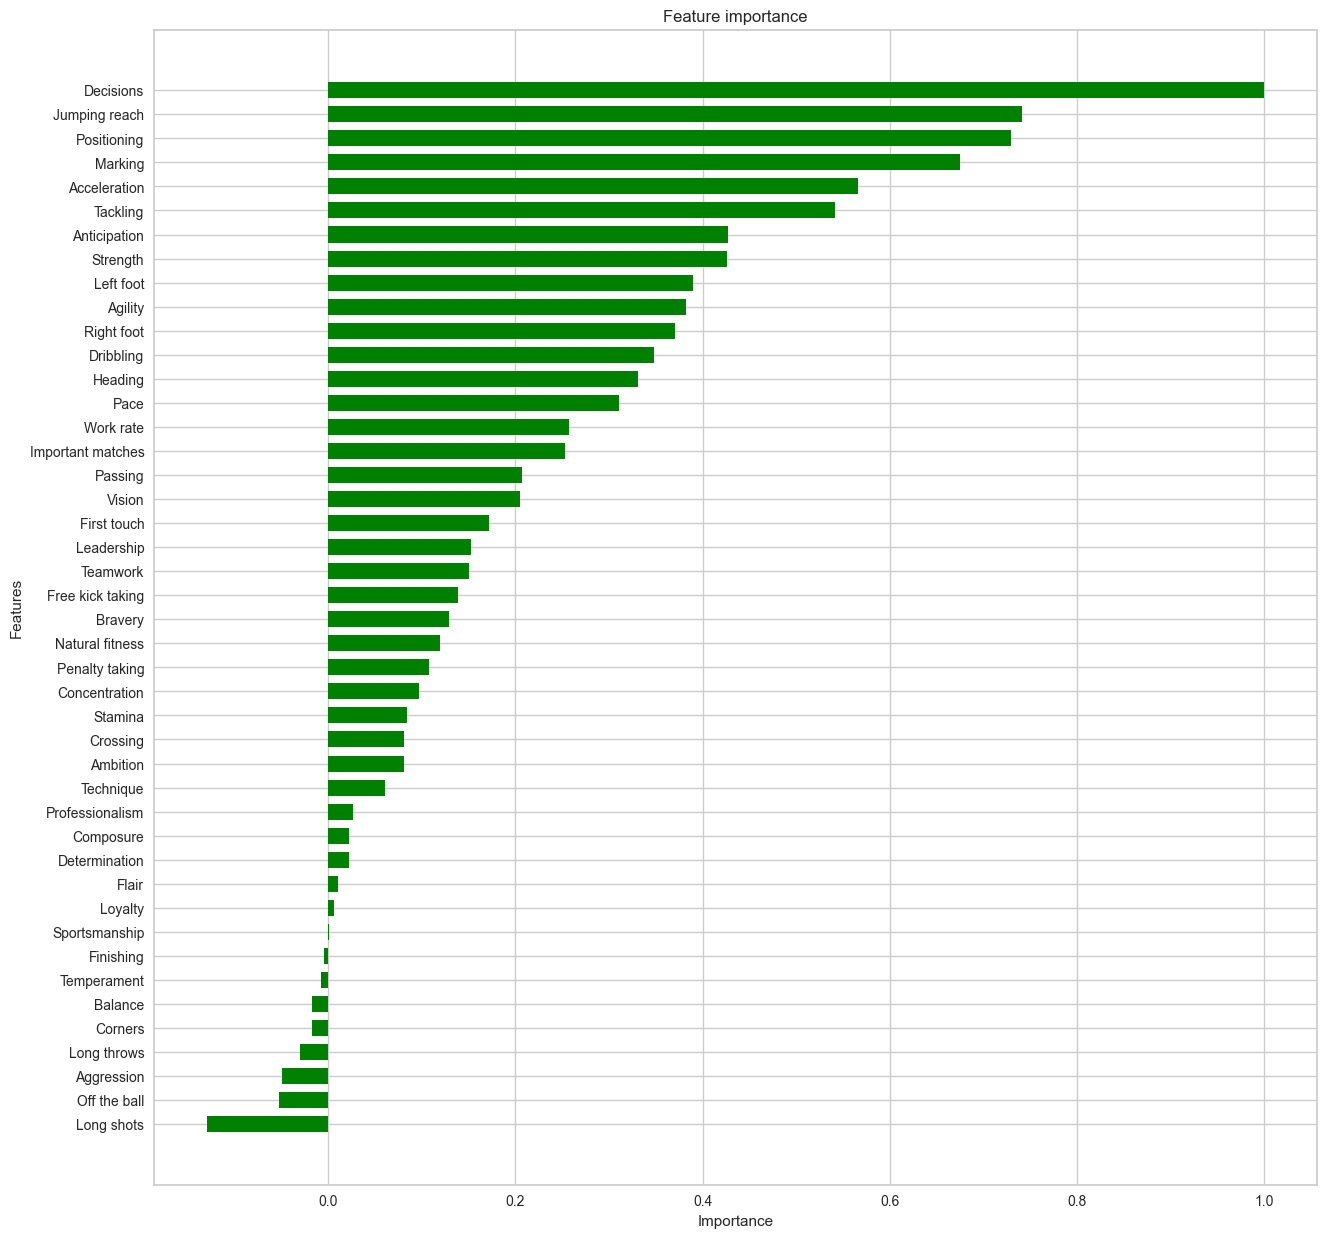

In [662]:
dc_db["perf_perso"] = dc_db["reputation"]**1.3 * (90 * (dc_db["Note moy"] - 6)\
+ 2 * dc_db["HdM"] + 15 * (dc_db["Pts/mat"] - 1)\
+ 0.03 * (dc_db["Poss remp/90"] - dc_db["Poss perd/90"])\
+ 0.05 * dc_db["Blq/90"]\
+ 0.1 * dc_db["Tcl/90"] + 0.015 * dc_db["Pres. e"] - 1.5 * (dc_db["pts_club"] - 1))

pd.set_option('display.max_columns', None)

X = dc_db[field_att + other_att]
y = dc_db["perf_perso"]

# Diviser le dataset en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

params = {
    'n_estimators': 100,
    'max_depth': 20,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
}

# Définir le modèle
rf_regressor_dc = LinearRegression()

# Entraîner le modèle
rf_regressor_dc.fit(X_train, y_train)

# Évaluer le modèle
y_pred = rf_regressor_dc.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MAE :", mae)
print("MSE :", mse)
print("R2 :", r2)
print("--------------------------------------------")

# Calculer l'importance des features
feature_importances = rf_regressor_dc.coef_
feature_names = X.columns

# Trier les features par ordre d'importance croissante
sorted_idx = np.argsort(feature_importances)
feature_importances = feature_importances[sorted_idx]
max_importance = max(feature_importances)
feature_importances_dc = [x/max_importance for x in feature_importances]
feature_names_dc = feature_names[sorted_idx]

# Tracer l'importance des features avec plus d'espace entre les barres
plt.figure(figsize=(15, 15))
bar_width = 1.2
plt.barh(np.arange(len(feature_names)) * bar_width, feature_importances_dc, color='green', align='center')
plt.yticks(np.arange(len(feature_names)) * bar_width, feature_names_dc, fontsize=10, rotation=0)
plt.title('Feature importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()

In [259]:
# Séparer les colonnes d'entrées du modèle et la colonne "Nom"
X_test = test_db.drop(['Nom', 'Poste'], axis=1)
nom_joueurs = test_db['Nom']
poste_joueur = test_db['Poste']

# Faire des prédictions sur X_test
predictions = rf_regressor_dc.predict(X_test)

# Aplatir le tableau de prédictions en un tableau 1D
predictions = predictions.flatten()

# Créer un nouveau dataframe avec les colonnes "Nom" et "prediction"
base_test_sorted = pd.DataFrame({'Nom': nom_joueurs, 'Poste': poste_joueur, 'prediction': predictions})

# Initialisation de MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 100))

# Transformation de la colonne
base_test_sorted['prediction'] = scaler.fit_transform(base_test_sorted[['prediction']])

# Trier le dataset en ordre décroissant selon la colonne "prediction"
base_test_sorted = base_test_sorted.sort_values('prediction', ascending=False)
base_test_sorted = base_test_sorted[base_test_sorted.Poste.str.contains("D \(C") | base_test_sorted.Poste.str.contains("D \(DC") | base_test_sorted.Poste.str.contains("D \(DGC")]

# Afficher les premières lignes du dataset trié
print(base_test_sorted.head(20).to_string())
print('--------------------------------')

                      Nom              Poste  prediction
24857     Virgil van Dijk              D (C)  100.000000
24704          Rúben Dias              D (C)   95.146313
18563  Alessandro Bastoni              D (C)   91.453199
18766     Aymeric Laporte              D (C)   90.402238
8753          John Stones              D (C)   89.916554
24770          Marquinhos          D (C), MD   88.587366
24564      Raphaël Varane              D (C)   88.503079
14544    Matthijs de Ligt          D (C), MD   88.163725
25108        Éder Militão              D (C)   87.873482
24851         Declan Rice   D (C), MD, M (C)   87.410489
21454             Fabinho  D (DC), MD, M (C)   87.241658
23493        Jules Koundé     D (DC), AL (D)   87.145378
15477          Pau Torres          D (C), MD   87.025150
24467    Presnel Kimpembe              D (C)   86.867117
9196    Kalidou Koulibaly              D (C)   86.362450
24329     Dayot Upamecano          D (C), MD   86.297258
15625        Mats Hummels      

In [ ]:
################## DG ####################

In [65]:
dg_db["perf_perso"] = (dg_db["reputation"] / dg_db["pts_club"]**0.5) * (4 * (dg_db["Note moy"] - 6) + dg_db["HdM"]/3 + 3 * (dg_db["Pts/mat"] - 1)\
+ 0.015 * (dg_db["FS"] - dg_db["FC"]) + 0.12 * dg_db["Déc/90"] + 0.003 * (dg_db["Poss remp/90"] - dg_db["Poss perd/90"])\
+ 0.02 * dg_db["Drb/90"] + 0.01 * dg_db["PCl/90"] + 0.01 * dg_db["Ct réu/90"] + 0.003 * dg_db["Têtes r/90"] - 0.1 * dg_db["Jaune"] - 2 * dg_db["Rou"]\
+ 0.003 * dg_db["Tcl/90"] + 0.003 * dg_db["Pres. e"] + 0.003 * dg_db["Int/90"] - 1.5 * (dc_db["pts_club"] - 1))

pd.set_option('display.max_columns', None)

dg_db[['Nom', 'Mins/mat', 'Drb/90', 'Occ. / 90 min.', 'PCl/90', 'Poss perd/90', 'Poss remp/90', 'Têtes r/90', 'Tcl D/90', 'Tcl/90',
       'FC', 'Note moy', 'FS', 'Int/90', 'Buts/90', 'Rou', 'Jaune', 'Ct réu/90', 'Ps T/90', 'Ps R/90', 'Déc/90',
       'HdM', 'Blq/90', 'Pres. e', 'Pts/mat', 'pts_club', 'reputation', 'perf_perso']].sort_values('perf_perso', ascending=False).head(5)

,Nom,Mins/mat,Drb/90,Occ. / 90 min.,PCl/90,Poss perd/90,Poss remp/90,Têtes r/90,Tcl D/90,Tcl/90,FC,Note moy,FS,Int/90,Buts/90,Rou,Jaune,Ct réu/90,Ps T/90,Ps R/90,Déc/90,HdM,Blq/90,Pres. e,Pts/mat,pts_club,reputation,perf_perso
18461,Enzo Díaz,3160.0,0.0,057,171.0,1367.0,1481.0,1139.0,000,399.0,4.0,7.00,3.0,456.0,0.0,0.0,0.0,285.0,4842,3873.0,57.0,0.0,114,684.0,0.85,1.097795,18.0,400.472540
10795,Kyle Walker-Peters,8422.0,373.0,010,112.0,1293.0,1222.0,558.0,000,276.0,42.0,6.77,46.0,295.0,0.0,0.0,3.0,193.0,3623,2786.0,10.0,2.0,083,610.0,1.44,1.096148,18.0,370.336917
22967,Destiny Udogie,8831.0,329.0,021,131.0,983.0,1354.0,815.0,000,329.0,50.0,7.15,62.0,324.0,0.0,0.0,4.0,78.0,3967,3193.0,10.0,4.0,152,666.0,1.26,1.240000,16.0,343.094015
10834,Kyle Walker-Peters,8576.0,385.0,012,95.0,1462.0,1097.0,572.0,000,387.0,40.0,6.78,54.0,347.0,0.0,0.0,2.0,167.0,3551,2843.0,7.0,1.0,065,605.0,1.14,1.096148,18.0,338.370419
10127,Antonino Gallo,3973.0,350.0,041,103.0,1215.0,412.0,556.0,000,185.0,2.0,6.96,4.0,350.0,21.0,0.0,0.0,185.0,3542,2471.0,21.0,1.0,144,700.0,1.18,0.915849,16.0,336.172738


MAE : 416.3665527022771
MSE : 281515.87811017886
R2 : 0.6982274159590223
------------------------------


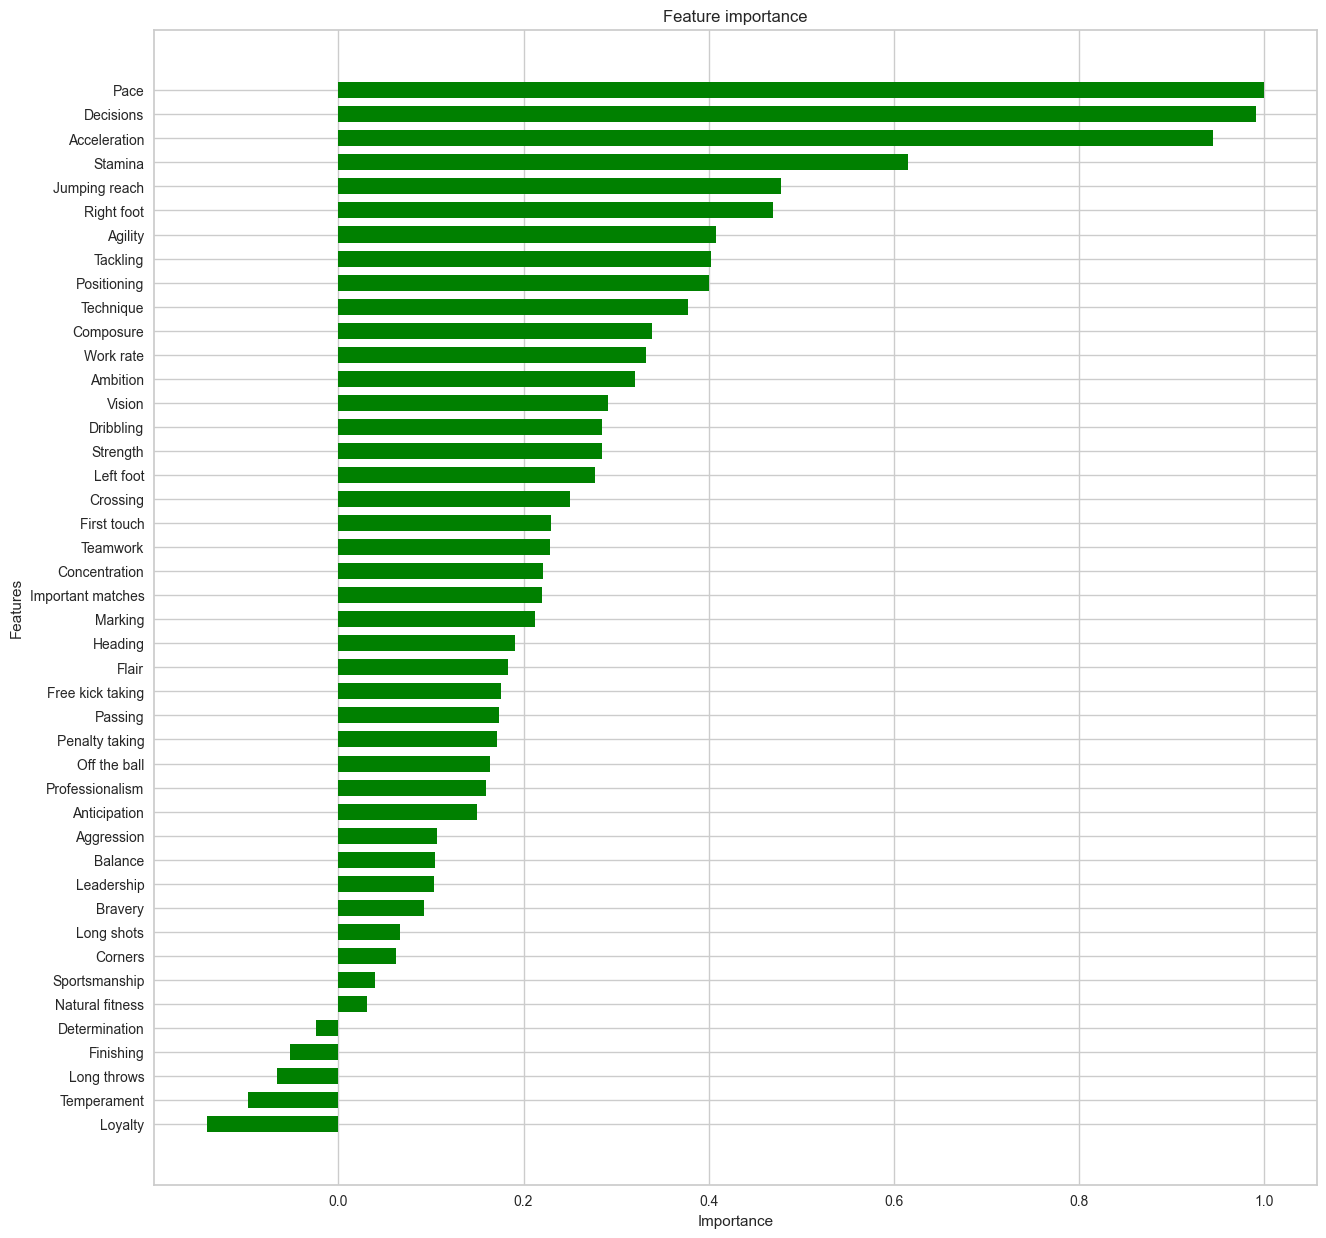

In [660]:
dg_db["perf_perso"] = dg_db["reputation"]**1.6 * (30 * (dg_db["Note moy"] - 6) + 0.2 * dg_db["HdM"] + 3 * (dg_db["Pts/mat"] - 1)\
+ 0.04 * (dg_db["FS"] - dg_db["FC"]) + 0.005 * (dg_db["Poss remp/90"] - dg_db["Poss perd/90"])\
+ 0.04 * dg_db["Drb/90"] + 0.002 * dg_db["PCl/90"] + 0.013 * dg_db["Ct réu/90"] + 0.003 * dg_db["Têtes r/90"]\
+ 0.008 * dg_db["Tcl/90"] + 0.01 * dg_db["Pres. e"])
X = dg_db[field_att + other_att]
y = dg_db["perf_perso"]

# Diviser le dataset en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définir le modèle
rf_regressor_dg = LinearRegression()

# Entraîner le modèle
rf_regressor_dg.fit(X_train, y_train)

# Évaluer le modèle
y_pred = rf_regressor_dg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MAE :", mae)
print("MSE :", mse)
print("R2 :", r2)
print('------------------------------')

# Calculer l'importance des features
feature_importances = rf_regressor_dg.coef_
feature_names = X.columns

# Trier les features par ordre d'importance croissante
sorted_idx = np.argsort(feature_importances)
feature_importances = feature_importances[sorted_idx]
max_importance = max(feature_importances)
feature_importances_dg = [x/max_importance for x in feature_importances]
feature_names_dg = feature_names[sorted_idx]

# Tracer l'importance des features avec plus d'espace entre les barres
plt.figure(figsize=(15, 15))
bar_width = 1.2
plt.barh(np.arange(len(feature_names)) * bar_width, feature_importances_dg, color='green', align='center')
plt.yticks(np.arange(len(feature_names)) * bar_width, feature_names_dg, fontsize=10, rotation=0)
plt.title('Feature importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()

In [270]:
# Séparer les colonnes d'entrées du modèle et la colonne "Nom"
X_test = test_db.drop(['Nom', 'Poste'], axis=1)
nom_joueurs = test_db['Nom']
poste_joueur = test_db['Poste']

# Faire des prédictions sur X_test
predictions = rf_regressor_dg.predict(X_test)

# Aplatir le tableau de prédictions en un tableau 1D
predictions = predictions.flatten()

# Créer un nouveau dataframe avec les colonnes "Nom" et "prediction"
base_test_sorted = pd.DataFrame({'Nom': nom_joueurs, 'Poste': poste_joueur, 'prediction': predictions})
base_test_sorted = base_test_sorted[base_test_sorted.Poste.str.contains("D \(G") | base_test_sorted.Poste.str.contains("AL \(G")\
                          | base_test_sorted.Poste.str.contains("D \(DG") | base_test_sorted.Poste.str.contains("AL \(DG")]

# Initialisation de MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 100))

# Transformation de la colonne
base_test_sorted['prediction'] = scaler.fit_transform(base_test_sorted[['prediction']])

# Trier le dataset en ordre décroissant selon la colonne "prediction"
base_test_sorted = base_test_sorted.sort_values('prediction', ascending=False)

# Afficher les premières lignes du dataset trié
print(base_test_sorted.head(20).to_string())
print('--------------------------------')

                       Nom                     Poste  prediction
20067         João Cancelo          D/AL (DG), M (D)  100.000000
13741         Ben Chilwell                  D/AL (G)   99.713322
20132       Joško Gvardiol                    D (GC)   97.574031
15357          David Alaba     D (GC), AL (G), M (C)   96.615961
6343       Kostas Tsimikas                  D/AL (G)   95.683870
25221        Pierre Kalulu                   D (DGC)   94.873478
23602    Takehiro Tomiyasu          D (DGC), AL (DG)   94.550470
9481            Nathan Aké                D (GC), MD   93.542658
18463      Benjamin Pavard           D (DGC), AL (D)   93.372212
18681      Lucas Hernández                    D (GC)   93.027884
18369       Kieran Tierney            D (GC), AL (G)   92.920054
16004                Nacho                   D (DGC)   92.831579
21256      Davide Calabria            D (DG), AL (D)   92.284017
5764             Joe Gomez               D (DGC), MD   91.865701
11968            Luke Sha

In [ ]:
###################### DD ########################

In [247]:
dd_db["perf_perso"] = dd_db["reputation"]**1.6 * (30 * (dd_db["Note moy"] - 6) + 0.2 * dd_db["HdM"] + 3 * (dd_db["Pts/mat"] - 1)\
+ 0.04 * (dd_db["FS"] - dd_db["FC"]) + 0.005 * (dd_db["Poss remp/90"] - dd_db["Poss perd/90"])\
+ 0.04 * dd_db["Drb/90"] + 0.002 * dd_db["PCl/90"] + 0.013 * dd_db["Ct réu/90"] + 0.003 * dd_db["Têtes r/90"]\
+ 0.008 * dd_db["Tcl/90"] + 0.01 * dd_db["Pres. e"])
X = dd_db[field_att + other_att]
y = dd_db["perf_perso"]

pd.set_option('display.max_columns', None)

dd_db[['Nom', 'Mins/mat', 'Drb/90', 'Occ. / 90 min.', 'PCl/90', 'Poss perd/90', 'Poss remp/90', 'Têtes r/90', 'Tcl D/90', 'Tcl/90',
       'FC', 'Note moy', 'FS', 'Int/90', 'Buts/90', 'Rou', 'Jaune', 'Ct réu/90', 'Ps T/90', 'Ps R/90', 'Déc/90',
       'HdM', 'Blq/90', 'Pres. e', 'Pts/mat', 'pts_club', 'reputation', 'perf_perso']].sort_values('perf_perso', ascending=False).head(5)

,Nom,Mins/mat,Drb/90,Occ. / 90 min.,PCl/90,Poss perd/90,Poss remp/90,Têtes r/90,Tcl D/90,Tcl/90,FC,Note moy,FS,Int/90,Buts/90,Rou,Jaune,Ct réu/90,Ps T/90,Ps R/90,Déc/90,HdM,Blq/90,Pres. e,Pts/mat,pts_club,reputation,perf_perso
136,Kyle Walker,8793.0,309.0,015,128.0,1610.0,1163.0,804.0,020,279.0,48.0,7.45,57.0,324.0,2.0,0.0,1.0,60.0,4666,3774.0,11.0,8.0,95.0,644.0,2.27,2.228242,18.0,7291.772344
757,Álvaro Odriozola,7542.0,328.0,010,159.0,1323.0,1094.0,766.0,020,298.0,9.0,7.40,9.0,308.0,0.0,0.0,1.0,50.0,4634,3550.0,30.0,1.0,109.0,587.0,2.83,2.167023,18.0,7258.126434
176,Kyle Walker,8757.0,339.0,010,109.0,1685.0,1147.0,865.0,018,246.0,50.0,7.42,45.0,371.0,2.0,0.0,6.0,54.0,4669,3706.0,8.0,8.0,99.0,599.0,2.12,2.228242,18.0,7107.019333
807,Trent Alexander-Arnold,8602.0,283.0,034,216.0,1070.0,1378.0,756.0,016,233.0,56.0,7.29,64.0,458.0,4.0,1.0,4.0,159.0,4703,3920.0,18.0,6.0,99.0,570.0,2.26,2.167023,18.0,7054.814186
2208,Cédric,9000.0,280.0,060,80.0,1600.0,1380.0,840.0,020,300.0,8.0,7.36,3.0,320.0,0.0,0.0,0.0,180.0,4280,3580.0,0.0,1.0,80.0,600.0,2.25,1.925633,18.0,6940.516731


a :  0.005
MAE : 96.55195060076416
MSE : 15371.560638961431
R2 : 0.6962868545337482
------------------------------


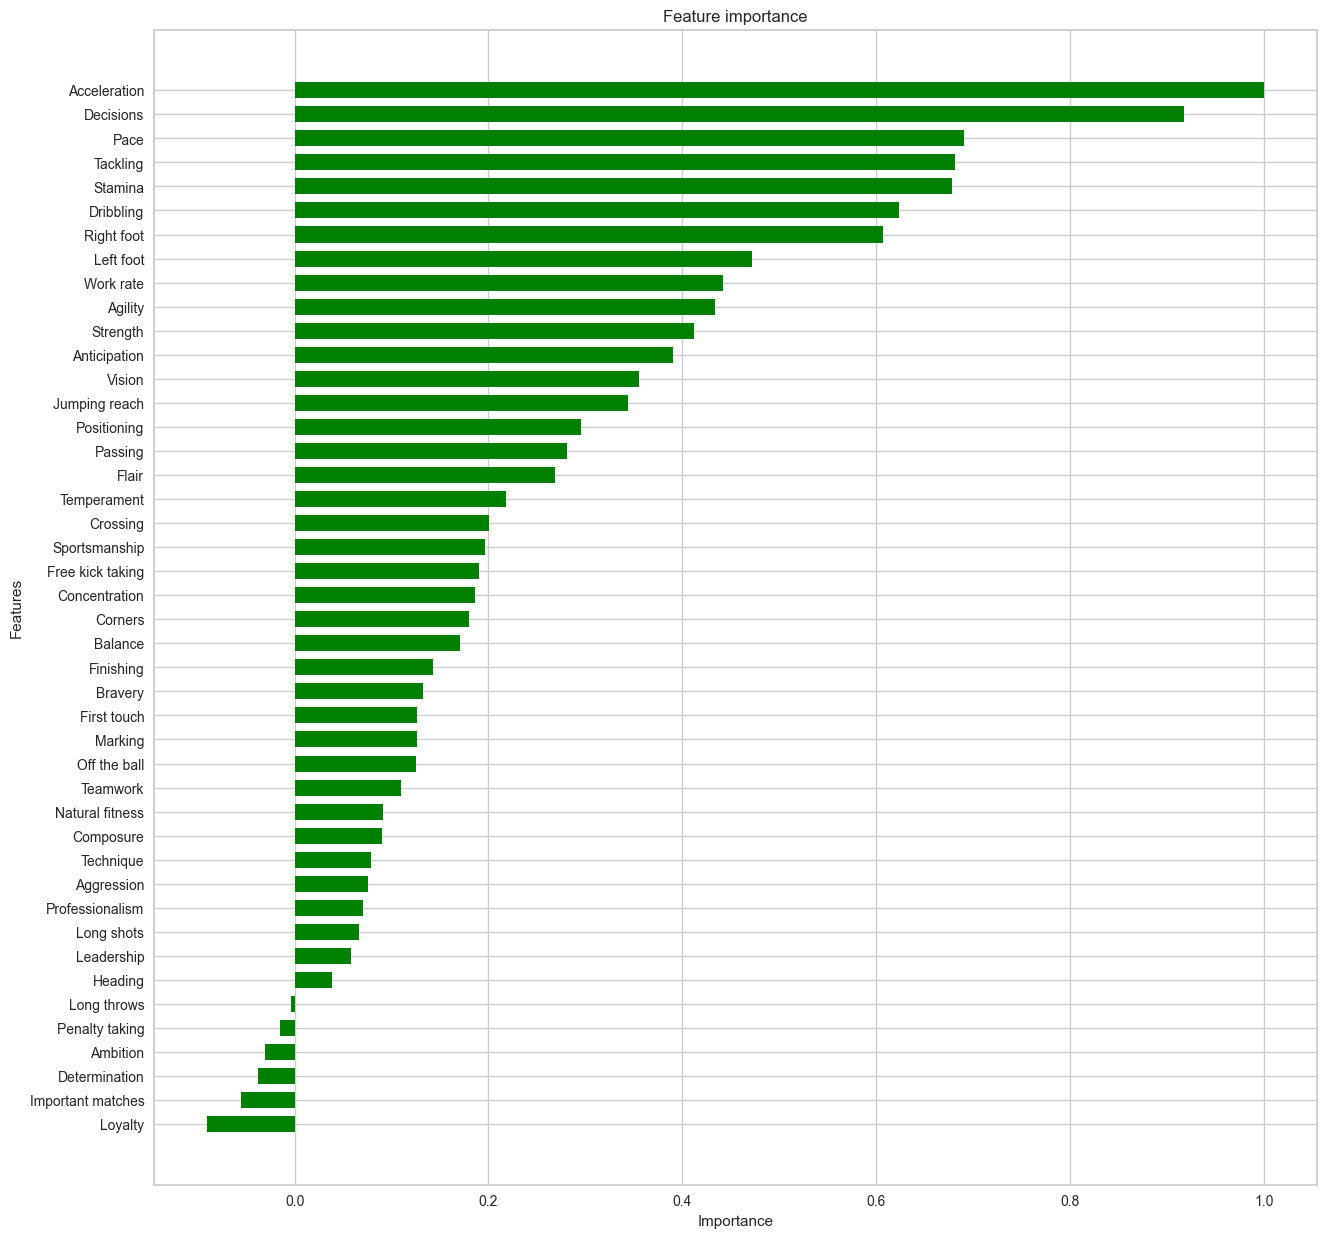

In [659]:
dd_db["perf_perso"] = dd_db["reputation"]**1.08 * (26 * (dd_db["Note moy"] - 6) + 0.8 * (dd_db["Pts/mat"] - 1)\
+ 0.04 * (dd_db["FS"] - dd_db["FC"]) + 0.007 * (dd_db["Poss remp/90"] - dd_db["Poss perd/90"])\
+ 0.035 * dd_db["Drb/90"] + 0.014 * dd_db["Ct réu/90"] + 0.002 * dd_db["Têtes r/90"]\
+ 0.03 * dd_db["Tcl/90"] + 0.01 * dd_db["Pres. e"])

X = dd_db[field_att + other_att]
y = dd_db["perf_perso"]

# Diviser le dataset en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    'n_estimators': 300,
    'max_depth': 30,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
}

# Définir le modèle
rf_regressor_dd = LinearRegression()

# Entraîner le modèle
rf_regressor_dd.fit(X_train, y_train)

# Évaluer le modèle
y_pred = rf_regressor_dd.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("a : ", a)
print("MAE :", mae)
print("MSE :", mse)
print("R2 :", r2)
print('------------------------------')

# Calculer l'importance des features
feature_importances = rf_regressor_dd.coef_
feature_names = X.columns

# Trier les features par ordre d'importance croissante
sorted_idx = np.argsort(feature_importances)
feature_importances = feature_importances[sorted_idx]
max_importance = max(feature_importances)
feature_importances_dd = [x/max_importance for x in feature_importances]
feature_names_dd = feature_names[sorted_idx]

# Tracer l'importance des features avec plus d'espace entre les barres
plt.figure(figsize=(15, 15))
bar_width = 1.2
plt.barh(np.arange(len(feature_names)) * bar_width, feature_importances_dd, color='green', align='center')
plt.yticks(np.arange(len(feature_names)) * bar_width, feature_names_dd, fontsize=10, rotation=0)
plt.title('Feature importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()

In [308]:
# Séparer les colonnes d'entrées du modèle et la colonne "Nom"
X_test = test_db.drop(['Nom', 'Poste'], axis=1)
nom_joueurs = test_db['Nom']
poste_joueur = test_db['Poste']

# Faire des prédictions sur X_test
predictions = rf_regressor_dd.predict(X_test)

# Aplatir le tableau de prédictions en un tableau 1D
predictions = predictions.flatten()
base_test_sorted = pd.DataFrame({'Nom': nom_joueurs, 'Poste': poste_joueur, 'prediction': predictions})
base_test_sorted = base_test_sorted[base_test_sorted.Poste.str.contains("D \(D") | base_test_sorted.Poste.str.contains("AL \(D")]

# Initialisation de MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 100))

# Transformation de la colonne
base_test_sorted['prediction'] = scaler.fit_transform(base_test_sorted[['prediction']])

# Trier le dataset en ordre décroissant selon la colonne "prediction"
base_test_sorted = base_test_sorted.sort_values('prediction', ascending=False)

# Afficher les premières lignes du dataset trié
print(base_test_sorted.head(20).to_string())
print('--------------------------------')

                          Nom                       Poste  prediction
24662          Joshua Kimmich         D/AL (D), MD, M (C)  100.000000
20067            João Cancelo            D/AL (DG), M (D)   94.437858
18072             Reece James          D (DC), AL (D), MD   93.315739
21164             Kyle Walker                    D/AL (D)   92.989094
23493            Jules Koundé              D (DC), AL (D)   92.582818
20534  Trent Alexander-Arnold            D/AL (D), M (DC)   91.430265
23602       Takehiro Tomiyasu            D (DGC), AL (DG)   89.887627
21454                 Fabinho           D (DC), MD, M (C)   89.764556
16004                   Nacho                     D (DGC)   87.881337
25221           Pierre Kalulu                     D (DGC)   87.290863
7915            Dani Carvajal                    D/AL (D)   86.383962
11992          Jurriën Timber          D (DC), AL (D), MD   86.188712
10288     Giovanni Di Lorenzo            D (DC), AL/M (D)   85.755275
21256         Davide

In [ ]:
###################### MDEF #########################

In [51]:
mdef_db["perf_perso"] = (mdef_db["reputation"] / mdef_db["pts_club"]**0.5) * (4 * (mdef_db["Note moy"] - 6) + mdef_db["HdM"]/3 + 3 * (mdef_db["Pts/mat"] - 1)\
+ 0.01 * (mdef_db["FS"] - mdef_db["FC"]) + 0.05 * mdef_db["Déc/90"] + 0.0065 * (mdef_db["Poss remp/90"] - mdef_db["Poss perd/90"])\
+ 0.023 * mdef_db["PCl/90"] + 0.015 * mdef_db["Têtes r/90"] - 0.1 * mdef_db["Jaune"] - 2 * mdef_db["Rou"]\
+ 0.002 * mdef_db["Ps R/90"] + 0.004 * mdef_db["Tcl/90"] + 0.004 * mdef_db["Pres. e"] + 0.004 * mdef_db["Int/90"])

pd.set_option('display.max_columns', None)

mdef_db[['Nom', 'Mins/mat', 'Drb/90', 'Occ. / 90 min.', 'PCl/90', 'Poss perd/90', 'Poss remp/90', 'Têtes r/90', 'Tcl D/90', 'Tcl/90',
       'FC', 'Note moy', 'FS', 'Int/90', 'Buts/90', 'Rou', 'Jaune', 'Ct réu/90', 'Ps T/90', 'Ps R/90', 'Déc/90',
       'HdM', 'Blq/90', 'Pres. e', 'Pts/mat', 'pts_club', 'reputation', 'perf_perso']].sort_values('perf_perso', ascending=False).head(5)

,Nom,Mins/mat,Drb/90,Occ. / 90 min.,PCl/90,Poss perd/90,Poss remp/90,Têtes r/90,Tcl D/90,Tcl/90,FC,Note moy,FS,Int/90,Buts/90,Rou,Jaune,Ct réu/90,Ps T/90,Ps R/90,Déc/90,HdM,Blq/90,Pres. e,Pts/mat,pts_club,reputation,perf_perso
18434,Kristoffer Ajer,8641.0,3.0,016,29.0,303.0,1448.0,1055.0,029,111.0,27.0,6.92,15.0,290.0,0.0,0.0,2.0,0.0,5976,5071.0,7.0,2.0,068,335.0,0.97,1.097795,18.0,709.638606
5697,Rúben Neves,6835.0,36.0,033,286.0,490.0,1603.0,329.0,013,388.0,48.0,7.07,19.0,267.0,0.0,0.0,8.0,76.0,6943,5935.0,33.0,3.0,089,836.0,1.50,1.253289,18.0,706.194178
3603,Boubacar Kamara,8379.0,19.0,011,30.0,187.0,1931.0,1047.0,033,132.0,28.0,7.09,15.0,286.0,0.0,0.0,4.0,6.0,6296,5816.0,8.0,0.0,083,264.0,1.82,1.548493,18.0,705.616202
18450,Kristoffer Ajer,8003.0,32.0,019,35.0,308.0,1584.0,758.0,016,228.0,41.0,7.00,21.0,257.0,0.0,0.0,3.0,10.0,6404,5610.0,10.0,0.0,064,459.0,1.49,1.097795,18.0,703.244966
18353,Kristoffer Ajer,7589.0,17.0,010,54.0,413.0,1427.0,918.0,024,193.0,26.0,7.06,13.0,268.0,3.0,0.0,4.0,7.0,6086,5412.0,3.0,2.0,068,437.0,1.00,1.097795,18.0,696.556355


a :  0.005
MAE : 7448.9329994046775
MSE : 91420143.06023727
R2 : 0.6773537695690053
------------------------------


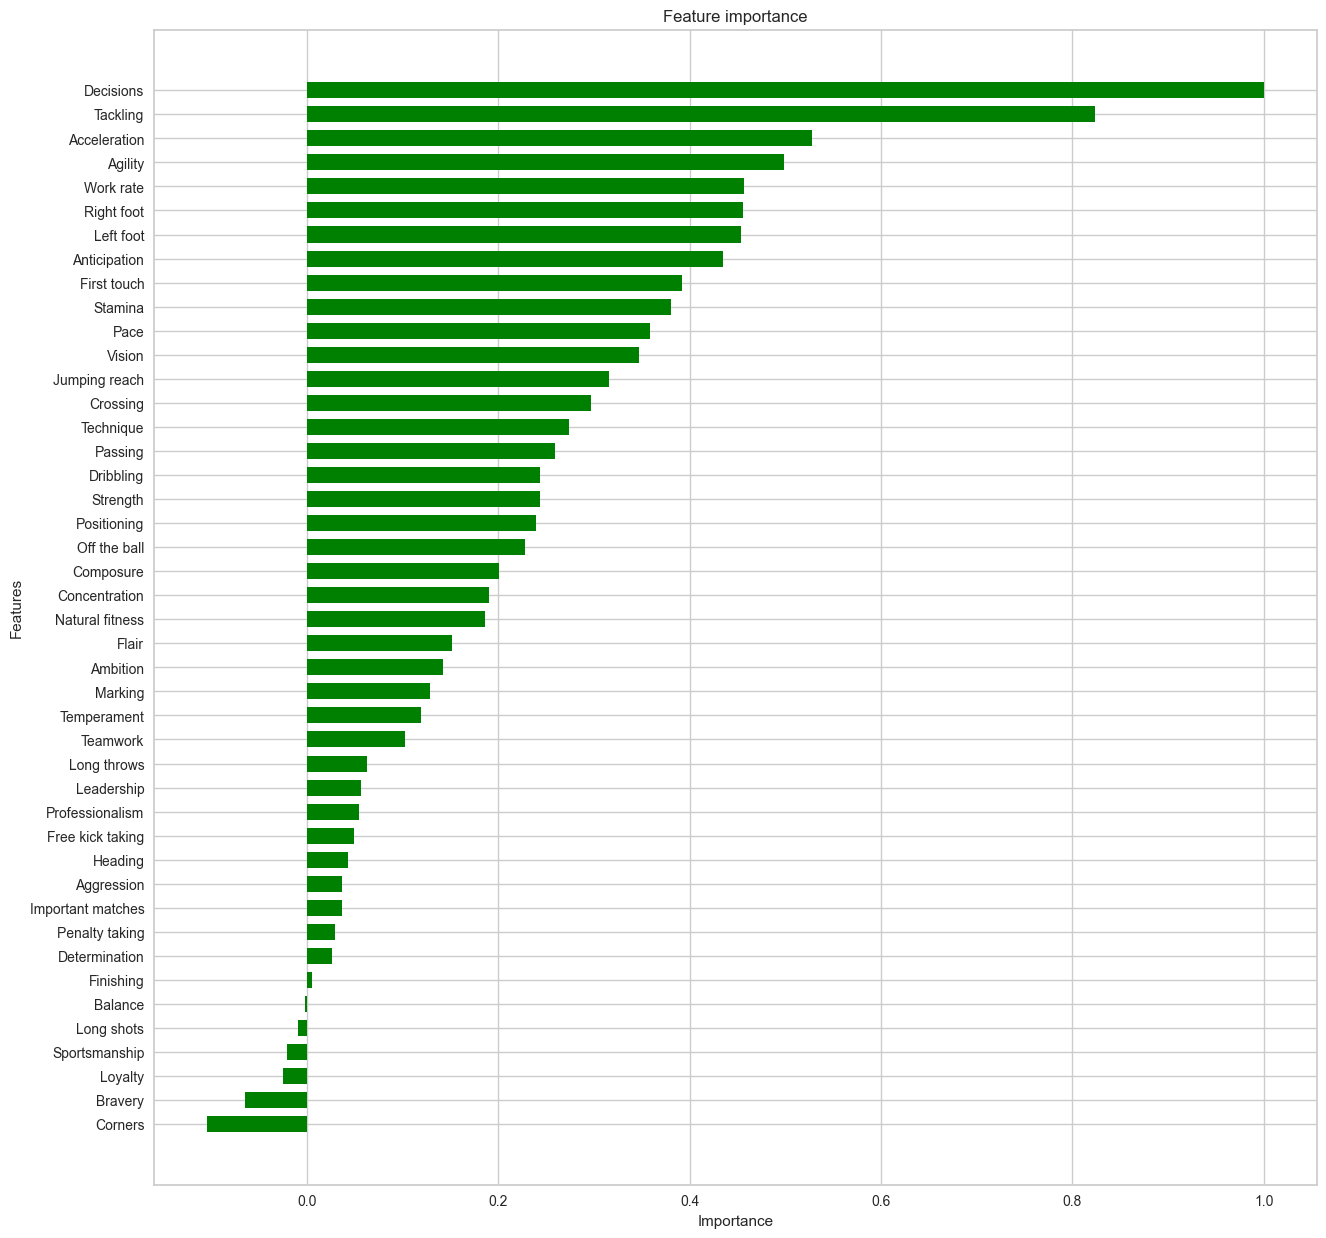

In [658]:
mdef_db["perf_perso"] = mdef_db["reputation"] ** 2.1 * (120 * (mdef_db["Note moy"] - 6) + mdef_db["HdM"] + 14 * (mdef_db["Pts/mat"] - 1)\
+ 0.024 * (mdef_db["Poss remp/90"] - mdef_db["Poss perd/90"])\
+ 0.004 * mdef_db["Ps R/90"] + 0.06 * mdef_db["Tcl/90"] + 0.008 * mdef_db["Pres. e"])

X = mdef_db[field_att + other_att]
y = mdef_db["perf_perso"]

# Diviser le dataset en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    'n_estimators': 300,
    'max_depth': 30,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
}

# Définir le modèle
rf_regressor_mdef = LinearRegression()

# Entraîner le modèle
rf_regressor_mdef.fit(X_train, y_train)

# Évaluer le modèle
y_pred = rf_regressor_mdef.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("a : ", a)
print("MAE :", mae)
print("MSE :", mse)
print("R2 :", r2)
print('------------------------------')

# Calculer l'importance des features
feature_importances = rf_regressor_mdef.coef_
feature_names = X.columns

# Trier les features par ordre d'importance croissante
sorted_idx = np.argsort(feature_importances)
feature_importances = feature_importances[sorted_idx]
max_importance = max(feature_importances)
feature_importances_mdef = [x/max_importance for x in feature_importances]
feature_names_mdef = feature_names[sorted_idx]

# Tracer l'importance des features avec plus d'espace entre les barres
plt.figure(figsize=(15, 15))
bar_width = 1.2
plt.barh(np.arange(len(feature_names)) * bar_width, feature_importances_mdef, color='green', align='center')
plt.yticks(np.arange(len(feature_names)) * bar_width, feature_names_mdef, fontsize=10, rotation=0)
plt.title('Feature importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()

In [355]:
# Séparer les colonnes d'entrées du modèle et la colonne "Nom"
X_test = test_db.drop(['Nom', 'Poste'], axis=1)
nom_joueurs = test_db['Nom']
poste_joueur = test_db['Poste']

# Faire des prédictions sur X_test
predictions = rf_regressor_mdef.predict(X_test)

# Aplatir le tableau de prédictions en un tableau 1D
predictions = predictions.flatten()
base_test_sorted = pd.DataFrame({'Nom': nom_joueurs, 'Poste': poste_joueur, 'prediction': predictions})
base_test_sorted = base_test_sorted[base_test_sorted.Poste.str.contains("MD")]

# Initialisation de MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 100))

# Transformation de la colonne
base_test_sorted['prediction'] = scaler.fit_transform(base_test_sorted[['prediction']])

# Trier le dataset en ordre décroissant selon la colonne "prediction"
base_test_sorted = base_test_sorted.sort_values('prediction', ascending=False)

# Afficher les premières lignes du dataset trié
print(base_test_sorted.head(20).to_string())
print('--------------------------------')

                       Nom                        Poste  prediction
20773                Rodri                    MD, M (C)  100.000000
21981         N'Golo Kanté                    MD, M (C)   97.424110
24662       Joshua Kimmich          D/AL (D), MD, M (C)   97.309749
24851          Declan Rice             D (C), MD, M (C)   95.463462
11152  Aurélien Tchouameni                    MD, M (C)   94.177535
20163      Frenkie de Jong             D (C), MD, M (C)   94.061293
19237       Nicolò Barella                    MD, M (C)   92.437011
9850         Mateo Kovačić                 MD, M/MO (C)   91.976125
8881         Leon Goretzka                 MD, M/MO (C)   91.713160
17647             Jorginho                    MD, M (C)   91.660152
12269               Thiago                 MD, M/MO (C)   90.277246
24554      Kevin De Bruyne  MD, M (DGC), MO (C), BT (C)   90.112043
24770           Marquinhos                    D (C), MD   89.928369
13825      Sergio Busquets                    MD

In [ ]:
#################### MC #######################

In [18]:
mc_db["perf_perso"] = (mc_db["reputation"] / mc_db["pts_club"]**0.5) * (4 * (mc_db["Note moy"] - 6) + mc_db["HdM"]/3 + 3 * (mc_db["Pts/mat"] - 1)\
+ 0.01 * (mc_db["FS"] - mc_db["FC"]) + 0.02 * mc_db["Buts/90"] + 0.13 * mc_db["Déc/90"] + 0.0045 * (mc_db["Poss remp/90"] - mc_db["Poss perd/90"])\
+ 0.035 * mc_db["PCl/90"] + 0.008 * mc_db["Têtes r/90"] - 0.1 * mc_db["Jaune"] - 2 * mc_db["Rou"]\
+ 0.0015 * mc_db["Ps R/90"] + 0.003 * mc_db["Tcl/90"] + 0.003 * mc_db["Pres. e"] + 0.003 * mc_db["Int/90"])

pd.set_option('display.max_columns', None)

mc_db[['Nom', 'Mins/mat', 'Drb/90', 'Occ. / 90 min.', 'PCl/90', 'Poss perd/90', 'Poss remp/90', 'Têtes r/90', 'Tcl D/90', 'Tcl/90',
       'FC', 'Note moy', 'FS', 'Int/90', 'Buts/90', 'Rou', 'Jaune', 'Ct réu/90', 'Ps T/90', 'Ps R/90', 'Déc/90',
       'HdM', 'Blq/90', 'Pres. e', 'Pts/mat', 'pts_club', 'reputation', 'perf_perso']].sort_values('perf_perso', ascending=False).head(5)

,Nom,Mins/mat,Drb/90,Occ. / 90 min.,PCl/90,Poss perd/90,Poss remp/90,Têtes r/90,Tcl D/90,Tcl/90,FC,Note moy,FS,Int/90,Buts/90,Rou,Jaune,Ct réu/90,Ps T/90,Ps R/90,Déc/90,HdM,Blq/90,Pres. e,Pts/mat,pts_club,reputation,perf_perso
5697,Rúben Neves,6835.0,36.0,033,286.0,490.0,1603.0,329.0,013,388.0,48.0,7.07,19.0,267.0,0.0,0.0,8.0,76.0,6943,5935.0,33.0,3.0,089,836.0,1.50,1.253289,18.0,659.317147
5617,Rúben Neves,7478.0,43.0,037,286.0,653.0,1570.0,329.0,3,329.0,49.0,7.05,29.0,265.0,5.0,0.0,7.0,83.0,6534,5713.0,43.0,3.0,088,805.0,1.29,1.253289,18.0,649.493089
10832,James Ward-Prowse,8510.0,38.0,050,310.0,1209.0,1320.0,222.0,000,332.0,66.0,7.21,36.0,295.0,3.0,0.0,5.0,151.0,6431,5454.0,38.0,6.0,083,803.0,1.14,1.096148,18.0,637.092158
5618,Rúben Neves,7250.0,47.0,059,275.0,547.0,1431.0,328.0,012,328.0,66.0,7.13,26.0,269.0,3.0,0.0,7.0,109.0,6922,6030.0,30.0,5.0,062,813.0,1.07,1.253289,18.0,623.183215
10807,James Ward-Prowse,8666.0,31.0,071,221.0,652.0,1299.0,192.0,007,351.0,75.0,7.08,28.0,323.0,0.0,0.0,5.0,106.0,6901,6048.0,20.0,5.0,099,776.0,1.21,1.096148,18.0,581.984606


a :  0.005
MAE : 1235.473832451005
MSE : 2494724.1797270584
R2 : 0.7124917739529069
------------------------------


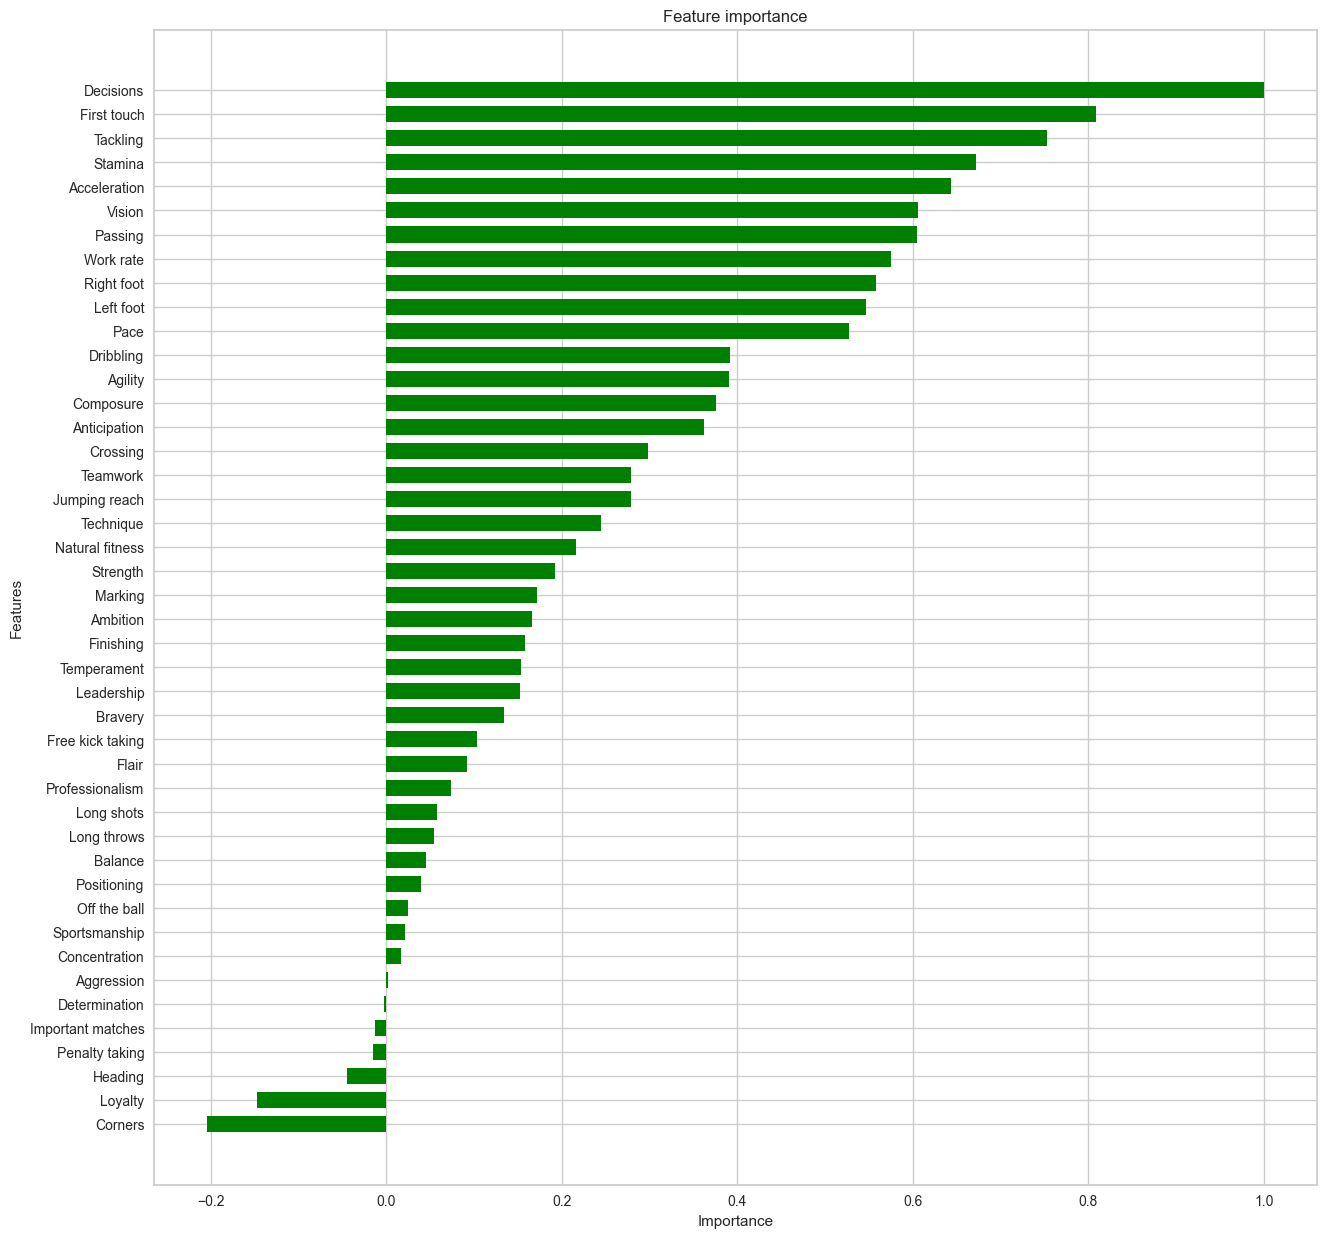

In [657]:
mc_db["perf_perso"] = mc_db["reputation"] ** 1.7 * (60 * (mc_db["Note moy"] - 6) + 0.8 * mc_db["HdM"] + 6 * (mc_db["Pts/mat"] - 1)\
+ 0.012 * (mc_db["Poss remp/90"] - mc_db["Poss perd/90"])\
+ 0.02 * mc_db["PCl/90"]\
+ 0.003 * mc_db["Ps R/90"] + 0.04 * mc_db["Tcl/90"] + 0.001 * mc_db["Pres. e"])

X = mc_db[field_att + other_att]
y = mc_db["perf_perso"]

# Diviser le dataset en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    'n_estimators': 300,
    'max_depth': 30,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
}

# Définir le modèle
rf_regressor_mc = LinearRegression()

# Entraîner le modèle
rf_regressor_mc.fit(X_train, y_train)

# Évaluer le modèle
y_pred = rf_regressor_mc.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("a : ", a)
print("MAE :", mae)
print("MSE :", mse)
print("R2 :", r2)
print('------------------------------')

# Calculer l'importance des features
feature_importances = rf_regressor_mc.coef_
feature_names = X.columns

# Trier les features par ordre d'importance croissante
sorted_idx = np.argsort(feature_importances)
feature_importances = feature_importances[sorted_idx]
max_importance = max(feature_importances)
feature_importances_mc = [x/max_importance for x in feature_importances]
feature_names_mc = feature_names[sorted_idx]

# Tracer l'importance des features avec plus d'espace entre les barres
plt.figure(figsize=(15, 15))
bar_width = 1.2
plt.barh(np.arange(len(feature_names)) * bar_width, feature_importances_mc, color='green', align='center')
plt.yticks(np.arange(len(feature_names)) * bar_width, feature_names_mc, fontsize=10, rotation=0)
plt.title('Feature importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()

In [423]:
# Séparer les colonnes d'entrées du modèle et la colonne "Nom"
X_test = test_db.drop(['Nom', 'Poste'], axis=1)
nom_joueurs = test_db['Nom']
poste_joueur = test_db['Poste']

# Faire des prédictions sur X_test
predictions = rf_regressor_mc.predict(X_test)

# Aplatir le tableau de prédictions en un tableau 1D
predictions = predictions.flatten()
base_test_sorted = pd.DataFrame({'Nom': nom_joueurs, 'Poste': poste_joueur, 'prediction': predictions})
base_test_sorted = base_test_sorted[base_test_sorted.Poste.str.contains("M \(GC") | base_test_sorted.Poste.str.contains("M \(C") | base_test_sorted.Poste.str.contains("M \(DC") | base_test_sorted.Poste.str.contains("M \(DGC")]

# Initialisation de MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 100))

# Transformation de la colonne
base_test_sorted['prediction'] = scaler.fit_transform(base_test_sorted[['prediction']])

# Trier le dataset en ordre décroissant selon la colonne "prediction"
base_test_sorted = base_test_sorted.sort_values('prediction', ascending=False)

# Afficher les premières lignes du dataset trié
print(base_test_sorted.head(20).to_string())
print('--------------------------------')

                          Nom                        Poste  prediction
24662          Joshua Kimmich          D/AL (D), MD, M (C)  100.000000
20773                   Rodri                    MD, M (C)   95.557281
24554         Kevin De Bruyne  MD, M (DGC), MO (C), BT (C)   92.625277
17647                Jorginho                    MD, M (C)   92.296264
19237          Nicolò Barella                    MD, M (C)   92.048121
21981            N'Golo Kanté                    MD, M (C)   91.793901
20163         Frenkie de Jong             D (C), MD, M (C)   91.442037
24851             Declan Rice             D (C), MD, M (C)   91.191990
14132                   Pedri              M (C), MO (DGC)   90.724387
20873           Jamal Musiala              M (C), MO (DGC)   90.451652
11152     Aurélien Tchouameni                    MD, M (C)   89.722336
17727       Stanislav Lobotka                    MD, M (C)   88.334221
20534  Trent Alexander-Arnold             D/AL (D), M (DC)   87.985571
17017 

In [ ]:
######################## MO #######################

In [19]:
mo_db["perf_perso"] = (mo_db["reputation"] / mo_db["pts_club"]**0.4) * (4 * (mo_db["Note moy"] - 6) + mo_db["HdM"]/3 + 3 * (mo_db["Pts/mat"] - 1)\
+ 0.025 * (mo_db["FS"] - mo_db["FC"]) + 0.06 * mo_db["Buts/90"] + 0.17 * mo_db["Déc/90"] + 0.003 * (mo_db["Poss remp/90"] - mo_db["Poss perd/90"])\
+ 0.02 * mo_db["Drb/90"] + 0.02 * mo_db["PCl/90"] - 0.1 * mo_db["Jaune"] - 2 * mo_db["Rou"])

pd.set_option('display.max_columns', None)

mo_db[['Nom', 'Mins/mat', 'Drb/90', 'Occ. / 90 min.', 'PCl/90', 'Poss perd/90', 'Poss remp/90', 'Têtes r/90', 'Tcl D/90', 'Tcl/90',
       'FC', 'Note moy', 'FS', 'Int/90', 'Buts/90', 'Rou', 'Jaune', 'Ct réu/90', 'Ps T/90', 'Ps R/90', 'Déc/90',
       'HdM', 'Blq/90', 'Pres. e', 'Pts/mat', 'pts_club', 'reputation', 'perf_perso']].sort_values('perf_perso', ascending=False).head(5)

,Nom,Mins/mat,Drb/90,Occ. / 90 min.,PCl/90,Poss perd/90,Poss remp/90,Têtes r/90,Tcl D/90,Tcl/90,FC,Note moy,FS,Int/90,Buts/90,Rou,Jaune,Ct réu/90,Ps T/90,Ps R/90,Déc/90,HdM,Blq/90,Pres. e,Pts/mat,pts_club,reputation,perf_perso
630,Lionel Messi,6902.0,100.0,043,411.0,963.0,1339.0,263.0,000,341.0,23.0,7.42,53.0,241.0,68.0,0.0,3.0,73.0,5010,4103.0,38.0,9.0,060,737.0,2.25,1.718805,16.0,447.928867
89,Kevin De Bruyne,8067.0,124.0,053,329.0,375.0,1509.0,251.0,000,319.0,25.0,7.56,33.0,350.0,31.0,0.0,1.0,46.0,6378,5535.0,37.0,7.0,074,834.0,2.42,2.228242,18.0,438.247742
145,Kevin De Bruyne,7736.0,121.0,061,302.0,372.0,1514.0,260.0,000,271.0,32.0,7.56,40.0,277.0,32.0,0.0,2.0,95.0,6263,5373.0,38.0,8.0,082,874.0,2.22,2.228242,18.0,428.937235
58,Kevin De Bruyne,7753.0,110.0,065,340.0,350.0,1456.0,238.0,0,327.0,27.0,7.33,45.0,277.0,16.0,0.0,3.0,55.0,6283,5401.0,37.0,8.0,096,838.0,2.31,2.228242,18.0,413.286128
484,Lionel Messi,7203.0,137.0,056,309.0,928.0,1390.0,178.0,0,337.0,13.0,7.39,29.0,303.0,53.0,0.0,2.0,59.0,5014,4195.0,41.0,5.0,056,737.0,2.30,1.718805,16.0,409.467689


a :  0.005
MAE : 2248.2777793946284
MSE : 8514222.137057977
R2 : 0.6768471381206289
------------------------------


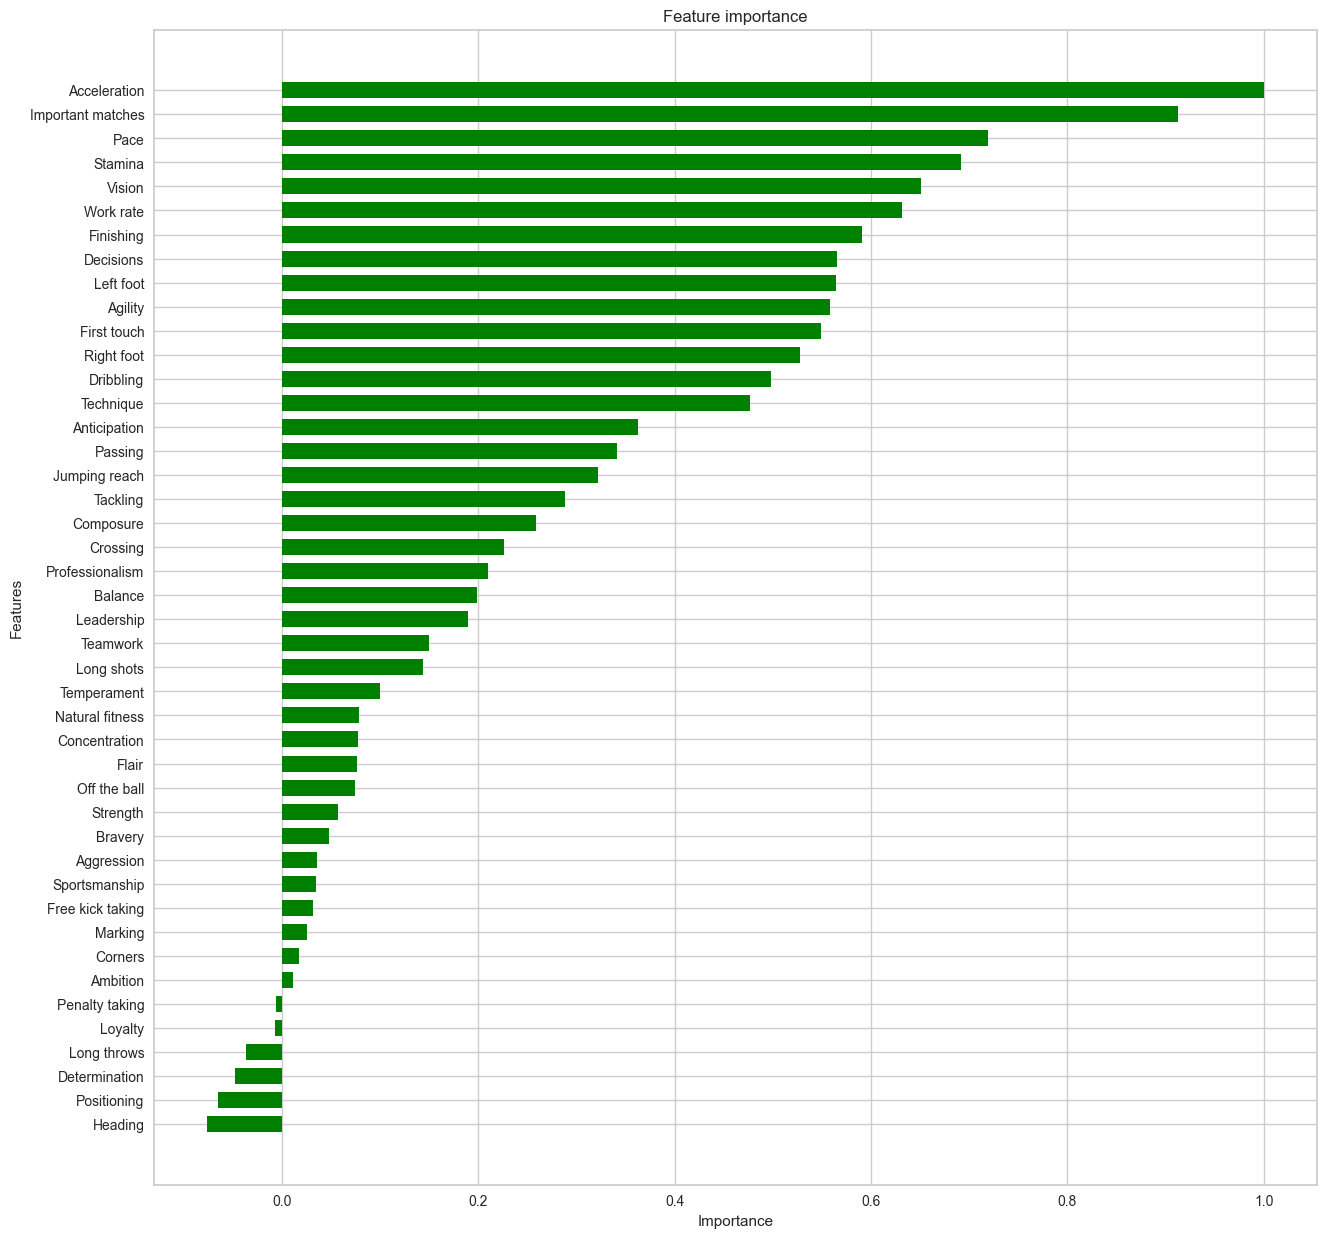

In [656]:
mo_db["perf_perso"] = mo_db["reputation"] ** 1.9 * (70 * (mo_db["Note moy"] - 6) + 0.2 * mo_db["HdM"] + 8 * (mo_db["Pts/mat"] - 1)\
+ 0.25 * (mo_db["FS"] - mo_db["FC"]) + 0.009 * (mo_db["Poss remp/90"] - mo_db["Poss perd/90"])\
+ 0.025 * mo_db["Drb/90"] + 0.04 * mo_db["PCl/90"] + 0.05 * mo_db["Tcl/90"])

X = mo_db[field_att + other_att]
y = mo_db["perf_perso"]

# Diviser le dataset en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    'n_estimators': 300,
    'max_depth': 30,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
}

# Définir le modèle
rf_regressor_mo =LinearRegression()

# Entraîner le modèle
rf_regressor_mo.fit(X_train, y_train)

# Évaluer le modèle
y_pred = rf_regressor_mo.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("a : ", a)
print("MAE :", mae)
print("MSE :", mse)
print("R2 :", r2)
print('------------------------------')


# Calculer l'importance des features
feature_importances = rf_regressor_mo.coef_
feature_names = X.columns

# Trier les features par ordre d'importance croissante
sorted_idx = np.argsort(feature_importances)
feature_importances = feature_importances[sorted_idx]
max_importance = max(feature_importances)
feature_importances_mo = [x/max_importance for x in feature_importances]
feature_names_mo = feature_names[sorted_idx]

# Tracer l'importance des features avec plus d'espace entre les barres
plt.figure(figsize=(15, 15))
bar_width = 1.2
plt.barh(np.arange(len(feature_names)) * bar_width, feature_importances_mo, color='green', align='center')
plt.yticks(np.arange(len(feature_names)) * bar_width, feature_names_mo, fontsize=10, rotation=0)
plt.title('Feature importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()

In [453]:
# Séparer les colonnes d'entrées du modèle et la colonne "Nom"
X_test = test_db.drop(['Nom', 'Poste'], axis=1)
nom_joueurs = test_db['Nom']
poste_joueur = test_db['Poste']

# Faire des prédictions sur X_test
predictions = rf_regressor_mo.predict(X_test)

# Aplatir le tableau de prédictions en un tableau 1D
predictions = predictions.flatten()
base_test_sorted = pd.DataFrame({'Nom': nom_joueurs, 'Poste': poste_joueur, 'prediction': predictions})
base_test_sorted = base_test_sorted[base_test_sorted.Poste.str.contains("MO \(GC") | base_test_sorted.Poste.str.contains("MO \(C") | base_test_sorted.Poste.str.contains("MO \(DC") | base_test_sorted.Poste.str.contains("MO \(DGC")]

# Initialisation de MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 100))

# Transformation de la colonne
base_test_sorted['prediction'] = scaler.fit_transform(base_test_sorted[['prediction']])

# Trier le dataset en ordre décroissant selon la colonne "prediction"
base_test_sorted = base_test_sorted.sort_values('prediction', ascending=False)

# Afficher les premières lignes du dataset trié
print(base_test_sorted.head(20).to_string())
print('--------------------------------')

                         Nom                        Poste  prediction
20473             Harry Kane              MO (GC), BT (C)  100.000000
20873          Jamal Musiala              M (C), MO (DGC)   99.615087
24838            Kai Havertz             M/MO (C), BT (C)   96.356717
23242         Bernardo Silva                    M/MO (DC)   96.297134
24554        Kevin De Bruyne  MD, M (DGC), MO (C), BT (C)   95.058959
20486          Karim Benzema               MO (C), BT (C)   94.269134
14398            Luka Modrić                     M/MO (C)   93.148229
21133             Sadio Mané             MO (DGC), BT (C)   92.415967
12696      Christian Eriksen                 MD, M/MO (C)   92.150645
15456           Lionel Messi       M (C), MO (DC), BT (C)   90.951522
19013             Phil Foden             MO (DGC), BT (C)   90.561428
24585        Bruno Fernandes             M/MO (C), BT (C)   89.970638
12069                Vitinha                 MD, M/MO (C)   89.626494
23247       Alexandr

In [ ]:
######################## MG #######################

In [20]:
mg_db["perf_perso"] = (mg_db["reputation"] / mg_db["pts_club"]**0.4) * (4 * (mg_db["Note moy"] - 6) + mg_db["HdM"]/3 + 3 * (mg_db["Pts/mat"] - 1)\
+ 0.025 * (mg_db["FS"] - mg_db["FC"]) + 0.08 * mg_db["Buts/90"] + 0.15 * mg_db["Déc/90"] + 0.002 * (mg_db["Poss remp/90"] - mg_db["Poss perd/90"])\
+ 0.03 * mg_db["Drb/90"] + 0.01 * mg_db["PCl/90"] + 0.012 * mg_db["Ct réu/90"] - 0.1 * mg_db["Jaune"] - 2 * mg_db["Rou"])

pd.set_option('display.max_columns', None)

mg_db[['Nom', 'Mins/mat', 'Drb/90', 'Occ. / 90 min.', 'PCl/90', 'Poss perd/90', 'Poss remp/90', 'Têtes r/90', 'Tcl D/90', 'Tcl/90',
       'FC', 'Note moy', 'FS', 'Int/90', 'Buts/90', 'Rou', 'Jaune', 'Ct réu/90', 'Ps T/90', 'Ps R/90', 'Déc/90',
       'HdM', 'Blq/90', 'Pres. e', 'Pts/mat', 'pts_club', 'reputation', 'perf_perso']].sort_values('perf_perso', ascending=False).head(5)

,Nom,Mins/mat,Drb/90,Occ. / 90 min.,PCl/90,Poss perd/90,Poss remp/90,Têtes r/90,Tcl D/90,Tcl/90,FC,Note moy,FS,Int/90,Buts/90,Rou,Jaune,Ct réu/90,Ps T/90,Ps R/90,Déc/90,HdM,Blq/90,Pres. e,Pts/mat,pts_club,reputation,perf_perso
2162,Bukayo Saka,7735.0,313.0,046,194.0,1256.0,749.0,349.0,000,315.0,36.0,7.64,59.0,230.0,51.0,0.0,2.0,61.0,4176,3389.0,22.0,14.0,044,734.0,2.06,1.925633,18.0,459.946698
979,Heung-Min Son,8193.0,346.0,008,166.0,1178.0,495.0,441.0,000,336.0,38.0,7.45,85.0,266.0,32.0,0.0,0.0,152.0,4258,3391.0,12.0,12.0,094,737.0,1.87,1.669053,18.0,446.449000
1011,Heung-Min Son,8239.0,316.0,012,180.0,1104.0,556.0,484.0,000,299.0,27.0,7.58,57.0,382.0,36.0,0.0,0.0,150.0,4315,3351.0,14.0,10.0,102,748.0,1.98,1.669053,18.0,444.459393
2132,Ricardo Horta,4985.0,316.0,027,208.0,1715.0,424.0,343.0,000,235.0,7.0,7.34,18.0,289.0,45.0,0.0,0.0,72.0,3746,2880.0,54.0,3.0,072,632.0,2.25,1.925633,18.0,442.182138
2072,Bukayo Saka,7888.0,301.0,050,182.0,1277.0,704.0,423.0,000,307.0,31.0,7.51,64.0,255.0,42.0,0.0,1.0,99.0,4127,3260.0,15.0,14.0,077,678.0,2.02,1.925633,18.0,429.255656


a :  0.005
MAE : 694.2526151182926
MSE : 799220.52432408
R2 : 0.7074505331801927
------------------------------


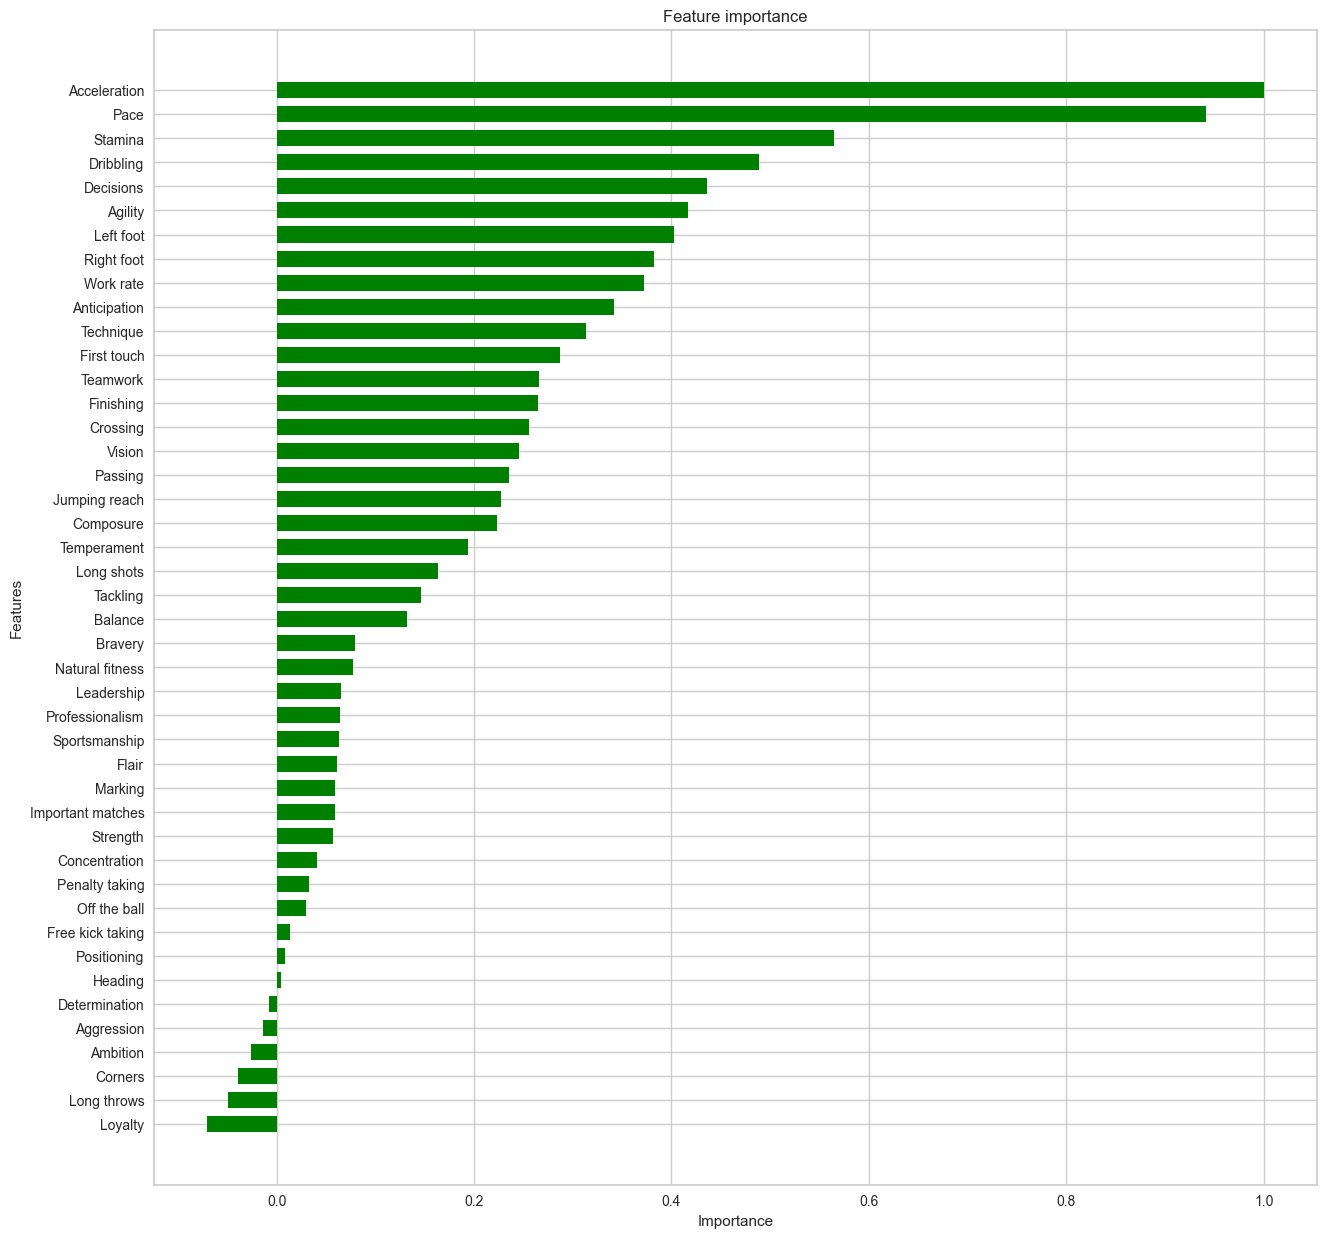

In [655]:
mg_db["perf_perso"] = mg_db["reputation"] ** 1.5 * (60 * (mg_db["Note moy"] - 6) + 0.02 * mg_db["HdM"] + 5 * (mg_db["Pts/mat"] - 1)\
+ 0.4 * (mg_db["FS"] - mg_db["FC"]) + 0.007 * (mg_db["Poss remp/90"] - mg_db["Poss perd/90"])\
+ 0.03 * mg_db["Drb/90"] + 0.01 * mg_db["PCl/90"] + 0.09 * mg_db["Tcl/90"] + 0.01 * mg_db["Blq/90"] + 0.03 * mg_db["Buts/90"])

X = mg_db[field_att + other_att]
y = mg_db["perf_perso"]

# Diviser le dataset en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définir le modèle
rf_regressor_mg = LinearRegression()

# Entraîner le modèle
rf_regressor_mg.fit(X_train, y_train)

# Évaluer le modèle
y_pred = rf_regressor_mg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("a : ", a)
print("MAE :", mae)
print("MSE :", mse)
print("R2 :", r2)
print('------------------------------')

# Calculer l'importance des features
feature_importances = rf_regressor_mg.coef_
feature_names = X.columns

# Trier les features par ordre d'importance croissante
sorted_idx = np.argsort(feature_importances)
feature_importances = feature_importances[sorted_idx]
max_importance = max(feature_importances)
feature_importances_mg = [x/max_importance for x in feature_importances]
feature_names_mg = feature_names[sorted_idx]

# Tracer l'importance des features avec plus d'espace entre les barres
plt.figure(figsize=(15, 15))
bar_width = 1.2
plt.barh(np.arange(len(feature_names)) * bar_width, feature_importances_mg, color='green', align='center')
plt.yticks(np.arange(len(feature_names)) * bar_width, feature_names_mg, fontsize=10, rotation=0)
plt.title('Feature importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()

In [473]:
# Séparer les colonnes d'entrées du modèle et la colonne "Nom"
X_test = test_db.drop(['Nom', 'Poste'], axis=1)
nom_joueurs = test_db['Nom']
poste_joueur = test_db['Poste']

# Faire des prédictions sur X_test
predictions = rf_regressor_mg.predict(X_test)

# Aplatir le tableau de prédictions en un tableau 1D
predictions = predictions.flatten()
base_test_sorted = pd.DataFrame({'Nom': nom_joueurs, 'Poste': poste_joueur, 'prediction': predictions})
base_test_sorted = base_test_sorted[base_test_sorted.Poste.str.contains("MO \(G") | base_test_sorted.Poste.str.contains("M \(G") | base_test_sorted.Poste.str.contains("MO \(DG") | base_test_sorted.Poste.str.contains("M \(DG")]

# Initialisation de MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 100))

# Transformation de la colonne
base_test_sorted['prediction'] = scaler.fit_transform(base_test_sorted[['prediction']])

# Trier le dataset en ordre décroissant selon la colonne "prediction"
base_test_sorted = base_test_sorted.sort_values('prediction', ascending=False)

# Afficher les premières lignes du dataset trié
print(base_test_sorted.head(20).to_string())
print('--------------------------------')

                   Nom                        Poste  prediction
23564    Kylian Mbappé              MO (DG), BT (C)  100.000000
25032    Mohamed Salah              MO (DG), BT (C)   98.621240
20473       Harry Kane              MO (GC), BT (C)   97.968846
20873    Jamal Musiala              M (C), MO (DGC)   95.867490
24425    Heung-Min Son             M/MO (G), BT (C)   94.811049
21133       Sadio Mané             MO (DGC), BT (C)   93.109673
24554  Kevin De Bruyne  MD, M (DGC), MO (C), BT (C)   92.275424
20660  Vinícius Júnior               M (G), MO (DG)   91.814741
19013       Phil Foden             MO (DGC), BT (C)   90.975641
24393        Luis Díaz                       MO (G)   90.950446
14132            Pedri              M (C), MO (DGC)   89.613857
14393           Neymar       M (G), MO (GC), BT (C)   88.304979
21057      Rafael Leão               MO (G), BT (C)   88.223226
17017      Mason Mount              M (C), MO (DGC)   88.001655
11477    Jack Grealish                  

In [ ]:
######################## MD #######################

In [21]:
md_db["perf_perso"] = (md_db["reputation"] / md_db["pts_club"]**0.4) * (4 * (md_db["Note moy"] - 6) + md_db["HdM"]/3 + 3 * (md_db["Pts/mat"] - 1)\
+ 0.025 * (md_db["FS"] - md_db["FC"]) + 0.08 * md_db["Buts/90"] + 0.15 * md_db["Déc/90"] + 0.002 * (md_db["Poss remp/90"] - md_db["Poss perd/90"])\
+ 0.03 * md_db["Drb/90"] + 0.01 * md_db["PCl/90"] + 0.012 * md_db["Ct réu/90"] - 0.1 * md_db["Jaune"] - 2 * md_db["Rou"])

pd.set_option('display.max_columns', None)

md_db[['Nom', 'Mins/mat', 'Drb/90', 'Occ. / 90 min.', 'PCl/90', 'Poss perd/90', 'Poss remp/90', 'Têtes r/90', 'Tcl D/90', 'Tcl/90',
       'FC', 'Note moy', 'FS', 'Int/90', 'Buts/90', 'Rou', 'Jaune', 'Ct réu/90', 'Ps T/90', 'Ps R/90', 'Déc/90',
       'HdM', 'Blq/90', 'Pres. e', 'Pts/mat', 'pts_club', 'reputation', 'perf_perso']].sort_values('perf_perso', ascending=False).head(5)

,Nom,Mins/mat,Drb/90,Occ. / 90 min.,PCl/90,Poss perd/90,Poss remp/90,Têtes r/90,Tcl D/90,Tcl/90,FC,Note moy,FS,Int/90,Buts/90,Rou,Jaune,Ct réu/90,Ps T/90,Ps R/90,Déc/90,HdM,Blq/90,Pres. e,Pts/mat,pts_club,reputation,perf_perso
884,Mohamed Salah,8483.0,280.0,027,194.0,498.0,666.0,399.0,000,284.0,35.0,7.83,96.0,256.0,55.0,0.0,1.0,68.0,4323,3428.0,29.0,20.0,057,737.0,2.19,2.167023,18.0,518.173540
694,Mohamed Salah,8494.0,269.0,022,228.0,563.0,663.0,414.0,000,322.0,44.0,7.77,76.0,249.0,55.0,0.0,0.0,84.0,4313,3345.0,27.0,18.0,047,679.0,2.07,2.167023,18.0,490.091903
740,Mohamed Salah,8280.0,282.0,032,246.0,496.0,718.0,445.0,000,287.0,50.0,7.84,81.0,255.0,46.0,0.0,0.0,95.0,4346,3438.0,15.0,19.0,049,698.0,2.30,2.167023,18.0,486.185990
762,Mohamed Salah,8266.0,297.0,042,194.0,437.0,733.0,478.0,0,247.0,41.0,7.78,76.0,277.0,54.0,0.0,0.0,90.0,4305,3405.0,18.0,15.0,076,705.0,2.41,2.167023,18.0,485.719232
14740,Iván Alejo,4440.0,486.0,-,203.0,1338.0,486.0,486.0,000,324.0,5.0,7.53,1.0,41.0,41.0,1.0,2.0,81.0,3689,2919.0,41.0,1.0,-,811.0,1.85,1.240629,16.0,469.858386


a :  0.005
MAE : 469.08194771757127
MSE : 364924.4744506272
R2 : 0.6800416586915623
------------------------------


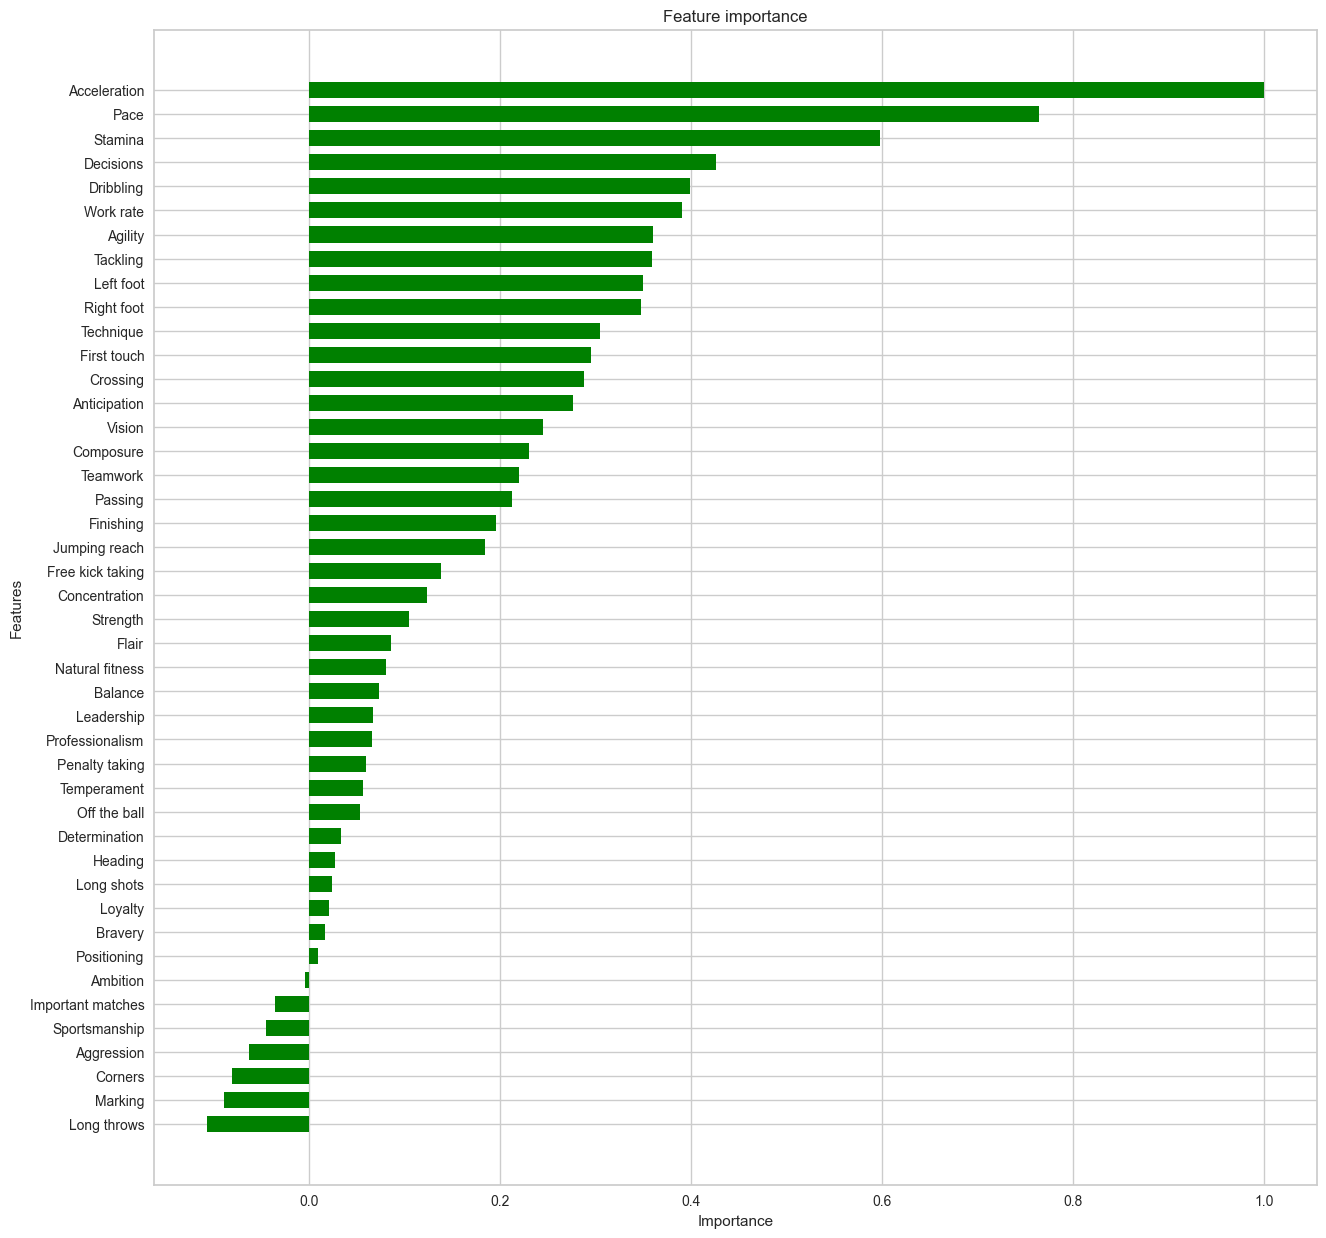

In [654]:
md_db["perf_perso"] = md_db["reputation"] ** 1.4 * (50 * (md_db["Note moy"] - 6) + 3 * (md_db["Pts/mat"] - 1)\
+ 0.45 * (md_db["FS"] - md_db["FC"]) + 0.008 * (md_db["Poss remp/90"] - md_db["Poss perd/90"])\
+ 0.02 * md_db["Drb/90"] + 0.11 * md_db["Tcl/90"] + 0.01 * md_db["Blq/90"] + 0.03 * md_db["Buts/90"])

X = md_db[field_att + other_att]
y = md_db["perf_perso"]

# Diviser le dataset en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définir le modèle
rf_regressor_md = LinearRegression()

# Entraîner le modèle
rf_regressor_md.fit(X_train, y_train)

# Évaluer le modèle
y_pred = rf_regressor_md.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("a : ", a)
print("MAE :", mae)
print("MSE :", mse)
print("R2 :", r2)
print('------------------------------')

# Calculer l'importance des features
feature_importances = rf_regressor_md.coef_
feature_names = X.columns

# Trier les features par ordre d'importance croissante
sorted_idx = np.argsort(feature_importances)
feature_importances = feature_importances[sorted_idx]
max_importance = max(feature_importances)
feature_importances_md = [x/max_importance for x in feature_importances]
feature_names_md = feature_names[sorted_idx]

# Tracer l'importance des features avec plus d'espace entre les barres
plt.figure(figsize=(15, 15))
bar_width = 1.2
plt.barh(np.arange(len(feature_names)) * bar_width, feature_importances_md, color='green', align='center')
plt.yticks(np.arange(len(feature_names)) * bar_width, feature_names_md, fontsize=10)
plt.title('Feature importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()

In [503]:
# Séparer les colonnes d'entrées du modèle et la colonne "Nom"
X_test = test_db.drop(['Nom', 'Poste'], axis=1)
nom_joueurs = test_db['Nom']
poste_joueur = test_db['Poste']

# Faire des prédictions sur X_test
predictions = rf_regressor_md.predict(X_test)

# Aplatir le tableau de prédictions en un tableau 1D
predictions = predictions.flatten()
base_test_sorted = pd.DataFrame({'Nom': nom_joueurs, 'Poste': poste_joueur, 'prediction': predictions})
base_test_sorted = base_test_sorted[base_test_sorted.Poste.str.contains("MO \(D") | base_test_sorted.Poste.str.contains("M \(D")]

# Initialisation de MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 100))

# Transformation de la colonne
base_test_sorted['prediction'] = scaler.fit_transform(base_test_sorted[['prediction']])

# Trier le dataset en ordre décroissant selon la colonne "prediction"
base_test_sorted = base_test_sorted.sort_values('prediction', ascending=False)

# Afficher les premières lignes du dataset trié
print(base_test_sorted.head(20).to_string())
print('--------------------------------')

                     Nom                        Poste  prediction
23564      Kylian Mbappé              MO (DG), BT (C)  100.000000
25032      Mohamed Salah              MO (DG), BT (C)   98.325915
23242     Bernardo Silva                    M/MO (DC)   95.287380
20660    Vinícius Júnior               M (G), MO (DG)   92.997460
24554    Kevin De Bruyne  MD, M (DGC), MO (C), BT (C)   92.943190
21133         Sadio Mané             MO (DGC), BT (C)   92.634930
20873      Jamal Musiala              M (C), MO (DGC)   92.589376
19013         Phil Foden             MO (DGC), BT (C)   91.705062
14132              Pedri              M (C), MO (DGC)   91.435885
17017        Mason Mount              M (C), MO (DGC)   91.054735
15456       Lionel Messi       M (C), MO (DC), BT (C)   89.410750
24513      Thomas Müller            M/MO (DC), BT (C)   89.065423
20067       João Cancelo             D/AL (DG), M (D)   88.362342
24740  Federico Valverde           MD, M (DC), MO (D)   88.352452
18217     

In [ ]:
######################## ST #######################

In [22]:
st_db["perf_perso"] = (st_db["reputation"] / st_db["pts_club"]**0.4) * (4 * (st_db["Note moy"] - 6) + st_db["HdM"]/3 + 3 * (st_db["Pts/mat"] - 1)\
+ 0.03 * (st_db["FS"] - st_db["FC"]) + 0.13 * st_db["Buts/90"] + 0.1 * st_db["Déc/90"] + 0.001 * (st_db["Poss remp/90"] - st_db["Poss perd/90"])\
+ 0.003 * st_db["Têtes r/90"])

# Mo Salah : 3.5, 6, 1.07, 0.7, 6, 2.7

pd.set_option('display.max_columns', None)

st_db[['Nom', 'Mins/mat', 'Drb/90', 'Occ. / 90 min.', 'PCl/90', 'Poss perd/90', 'Poss remp/90', 'Têtes r/90', 'Tcl D/90', 'Tcl/90',
       'FC', 'Note moy', 'FS', 'Int/90', 'Buts/90', 'Rou', 'Jaune', 'Ct réu/90', 'Ps T/90', 'Ps R/90', 'Déc/90',
       'HdM', 'Blq/90', 'Pres. e', 'Pts/mat', 'pts_club', 'reputation', 'perf_perso']].sort_values('perf_perso', ascending=False).head(5)

,Nom,Mins/mat,Drb/90,Occ. / 90 min.,PCl/90,Poss perd/90,Poss remp/90,Têtes r/90,Tcl D/90,Tcl/90,FC,Note moy,FS,Int/90,Buts/90,Rou,Jaune,Ct réu/90,Ps T/90,Ps R/90,Déc/90,HdM,Blq/90,Pres. e,Pts/mat,pts_club,reputation,perf_perso
884,Mohamed Salah,8483.0,280.0,027,194.0,498.0,666.0,399.0,000,284.0,35.0,7.83,96.0,256.0,55.0,0.0,1.0,68.0,4323,3428.0,29.0,20.0,057,737.0,2.19,2.167023,18.0,406.912718
2826,Chérif N'Diaye,3660.0,49.0,-,49.0,1279.0,639.0,344.0,000,639.0,8.0,7.08,1.0,98.0,148.0,1.0,1.0,0.0,6197,3885.0,98.0,0.0,098,590.0,1.25,1.095556,12.0,396.753071
7551,Fer Niño,3900.0,77.0,038,154.0,1577.0,115.0,769.0,000,115.0,0.0,7.42,4.0,115.0,154.0,0.0,0.0,0.0,3269,2769.0,0.0,1.0,038,385.0,2.20,1.798655,16.0,387.113736
90,Erling Haaland,7735.0,135.0,028,167.0,446.0,334.0,586.0,000,239.0,42.0,7.59,158.0,182.0,72.0,1.0,1.0,8.0,3594,2835.0,15.0,7.0,028,616.0,2.40,2.228242,18.0,377.289514
694,Mohamed Salah,8494.0,269.0,022,228.0,563.0,663.0,414.0,000,322.0,44.0,7.77,76.0,249.0,55.0,0.0,0.0,84.0,4313,3345.0,27.0,18.0,047,679.0,2.07,2.167023,18.0,375.739803


a : 0.005
MAE : 531.0108683344113
MSE : 481000.56762425473
R2 : 0.6785233600718628
-------------------------


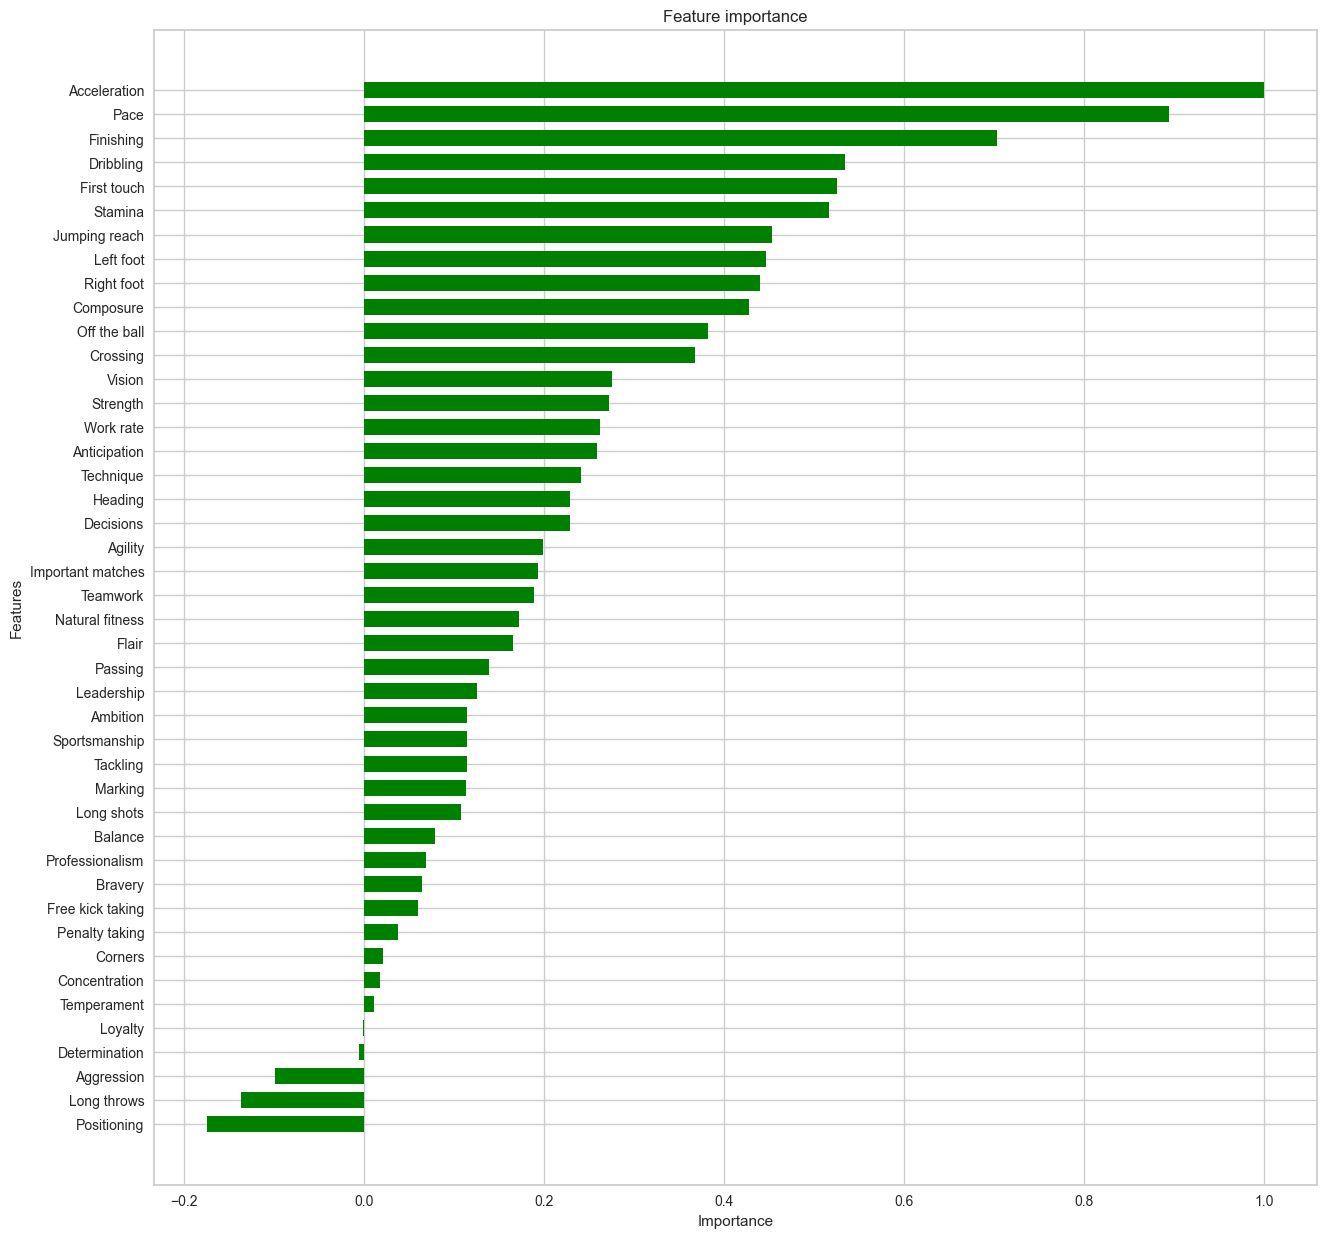

In [653]:
st_db["perf_perso"] = st_db["reputation"] ** 1.4 * (50 * (st_db["Note moy"] - 6) + 5 * (st_db["Pts/mat"] - 1)\
+ 0.6 * (st_db["FS"] - st_db["FC"]) + 0.003 * (st_db["Poss remp/90"] - st_db["Poss perd/90"])\
+ 0.11 * st_db["Tcl/90"] + 0.03 * st_db["Blq/90"] + 0.16 * st_db["Buts/90"] + 0.08 * st_db["Déc/90"] + 0.002 * st_db["Têtes r/90"])

X = st_db[field_att + other_att]
y = st_db["perf_perso"]

# Diviser le dataset en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définir le modèle
rf_regressor_st = LinearRegression()

# Entraîner le modèle
rf_regressor_st.fit(X_train, y_train)

# Évaluer le modèle
y_pred = rf_regressor_st.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("a :", a)
print("MAE :", mae)
print("MSE :", mse)
print("R2 :", r2)
print('-------------------------')

# Calculer l'importance des features
feature_importances = rf_regressor_st.coef_
feature_names = X.columns

# Trier les features par ordre d'importance croissante
sorted_idx = np.argsort(feature_importances)
feature_importances = feature_importances[sorted_idx]
max_importance = max(feature_importances)
feature_importances_st = [x/max_importance for x in feature_importances]
feature_names_st = feature_names[sorted_idx]

# Tracer l'importance des features avec plus d'espace entre les barres
plt.figure(figsize=(15, 15))
bar_width = 1.2
plt.barh(np.arange(len(feature_names)) * bar_width, feature_importances_st, color='green', align='center')
plt.yticks(np.arange(len(feature_names)) * bar_width, feature_names_st, fontsize=10)
plt.title('Feature importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()

In [646]:
# Séparer les colonnes d'entrées du modèle et la colonne "Nom"
X_test = test_db.drop(['Nom', 'Poste'], axis=1)
nom_joueurs = test_db['Nom']
poste_joueur = test_db['Poste']

# Faire des prédictions sur X_test
predictions = rf_regressor_st.predict(X_test)

# Aplatir le tableau de prédictions en un tableau 1D
predictions = predictions.flatten()
base_test_sorted = pd.DataFrame({'Nom': nom_joueurs, 'Poste': poste_joueur, 'prediction': predictions})
base_test_sorted = base_test_sorted[base_test_sorted.Poste.str.contains("BT")]

# Initialisation de MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 100))

# Transformation de la colonne
base_test_sorted['prediction'] = scaler.fit_transform(base_test_sorted[['prediction']])

# Trier le dataset en ordre décroissant selon la colonne "prediction"
base_test_sorted = base_test_sorted.sort_values('prediction', ascending=False)

# Afficher les premières lignes du dataset trié
print(base_test_sorted.head(20).to_string())
print('--------------------------------')

                      Nom                        Poste  prediction
24546      Erling Haaland                       BT (C)  100.000000
23564       Kylian Mbappé              MO (DG), BT (C)   97.237106
20473          Harry Kane              MO (GC), BT (C)   94.181472
25032       Mohamed Salah              MO (DG), BT (C)   91.952961
24425       Heung-Min Son             M/MO (G), BT (C)   90.035898
20486       Karim Benzema               MO (C), BT (C)   89.963069
25191  Robert Lewandowski                       BT (C)   89.851502
24838         Kai Havertz             M/MO (C), BT (C)   88.310091
21133          Sadio Mané             MO (DGC), BT (C)   87.708661
14393              Neymar       M (G), MO (GC), BT (C)   86.765813
15456        Lionel Messi       M (C), MO (DC), BT (C)   85.523138
18494       Romelu Lukaku                       BT (C)   85.497598
20938      Victor Osimhen                       BT (C)   85.227049
21057         Rafael Leão               MO (G), BT (C)   84.87

In [ ]:
################## Global #####################

In [647]:
global_feature_importance = [0] * len(feature_names_dc)

i = 0
for attribute in global_feature_names:
    global_feature_importance[i] = feature_importances_dc[feature_names_dc.to_list().index(attribute)]\
    + feature_importances_dg[feature_names_dg.to_list().index(attribute)]\
    + feature_importances_dd[feature_names_dd.to_list().index(attribute)]\
    + feature_importances_dd[feature_names_dd.to_list().index(attribute)]\
    + feature_importances_mdef[feature_names_mdef.to_list().index(attribute)]\
    + feature_importances_mc[feature_names_mc.to_list().index(attribute)]\
    + feature_importances_mo[feature_names_mo.to_list().index(attribute)]\
    + feature_importances_mg[feature_names_mg.to_list().index(attribute)]\
    + feature_importances_md[feature_names_md.to_list().index(attribute)]\
    + feature_importances_st[feature_names_st.to_list().index(attribute)]
    i += 1

In [648]:
sorted_indices = np.argsort(global_feature_importance)
sorted_feature_names = [global_feature_names[i] for i in sorted_indices]
sorted_feature_importance = [global_feature_importance[i] for i in sorted_indices]

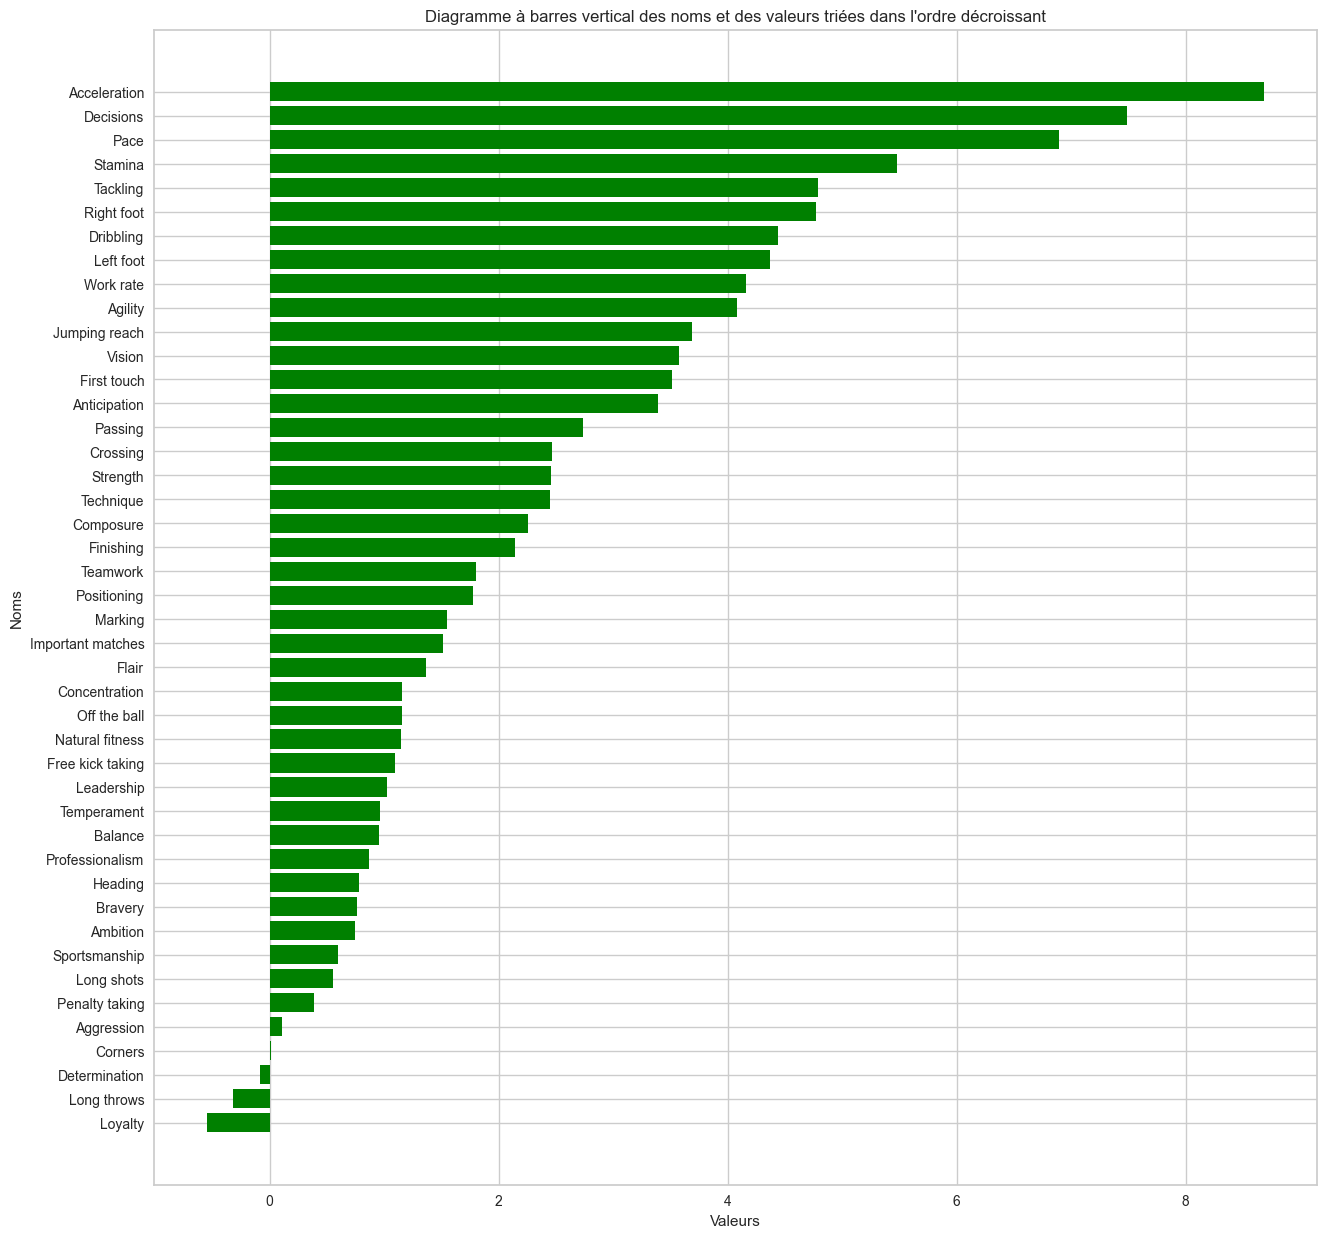

In [649]:
plt.figure(figsize=(15, 15))
plt.barh(sorted_feature_names, sorted_feature_importance, color='green')
plt.xlabel('Valeurs')
plt.ylabel('Noms')
plt.title('Diagramme à barres vertical des noms et des valeurs triées dans l\'ordre décroissant')
plt.show()

In [29]:
################### Testing the model ##################

In [96]:
test_db.drop('Nom', axis=1).shape

(33777, 44)

In [98]:
for test_model in [rf_regressor_st, rf_regressor_md, rf_regressor_mg, rf_regressor_mo,\
                   rf_regressor_mc, rf_regressor_mdef, rf_regressor_dd, rf_regressor_dg, rf_regressor_dc]:
    # Séparer les colonnes d'entrées du modèle et la colonne "Nom"
    X_test = test_db.drop('Nom', axis=1)
    nom_joueurs = test_db['Nom']

    # Faire des prédictions sur X_test
    predictions = test_model.predict(X_test)

    # Aplatir le tableau de prédictions en un tableau 1D
    predictions = predictions.flatten()

    # Créer un nouveau dataframe avec les colonnes "Nom" et "prediction"
    base_test_sorted = pd.DataFrame({'Nom': nom_joueurs, 'prediction': predictions})

    # Trier le dataset en ordre décroissant selon la colonne "prediction"
    base_test_sorted = base_test_sorted.sort_values('prediction', ascending=False)

    # Afficher les premières lignes du dataset trié
    print(base_test_sorted.head(10).to_string())
    print('--------------------------------')

                    Nom  prediction
917      Michael Olunga  248.923122
1028        Lucas Höler  238.275584
877   Baghdad Bounedjah  230.967666
1002           Fer Niño  221.257997
2281    Ludovic Ajorque  220.900318
66      Odsonne Edouard  218.434604
251       Antonín Barák  215.177086
1542       Steve Mounié  214.545660
3723         Pedro Raul  211.001973
120      Stevan Jovetić  210.989651
--------------------------------
                      Nom  prediction
1436                Josué  301.621584
362          Harry Wilson  282.560021
2482         Martín Ojeda  276.646627
3132  Andreas Schjelderup  274.591564
532       Woo-yeong Jeong  271.199568
14        Florian Thauvin  262.094377
3929                Diego  258.081886
113        Rachid Ghezzal  256.415408
3079       Álvaro Fidalgo  256.318565
1632      Sebastián Villa  256.108631
--------------------------------
                     Nom  prediction
5928  Francisco González  273.933130
14       Florian Thauvin  271.230315
2482     

In [39]:
########### Compare all models ##########

In [163]:
dc_db["perf_perso"] = dc_db["reputation"]**1.5 * (100 * (dc_db["Note moy"] - 6)\
    + 2 * dc_db["HdM"] + 15 * (dc_db["Pts/mat"]/dc_db["pts_club"])\
    + 0.03 * (dc_db["Poss remp/90"] - dc_db["Poss perd/90"])\
    + 0.05 * dc_db["Blq/90"]\
    + 0.1 * dc_db["Tcl/90"] + 0.015 * dc_db["Pres. e"])
pd.set_option('display.max_columns', None)

X = dc_db[field_att + other_att]
y = dc_db["perf_perso"]

# Concaténez X et y pour créer un DataFrame unique
data = pd.concat([X, pd.Series(y, name='target')], axis=1)

# Initialisez l'environnement de PyCaret
exp_reg = setup(data, target='target', session_id=123, normalize=True)

# # Comparez plusieurs modèles
# best_models = compare_models()

# # Affichez les résultats avec les métriques MSE, MAE et R² score
# print(pull().sort_values(['R2', 'MAE', 'MSE'], ascending=[False, True, True]))

# Création d'un modèle précis
lightgbm = create_model('lr')

# launch evaluate widget
evaluate_model(lightgbm)

In [229]:
dg_db["perf_perso"] = dg_db["reputation"]**1.6 * (30 * (dg_db["Note moy"] - 6) + 0.2 * dg_db["HdM"] + 3 * (dg_db["Pts/mat"] - 1)\
+ 0.04 * (dg_db["FS"] - dg_db["FC"]) + 0.005 * (dg_db["Poss remp/90"] - dg_db["Poss perd/90"])\
+ 0.04 * dg_db["Drb/90"] + 0.002 * dg_db["PCl/90"] + 0.013 * dg_db["Ct réu/90"] + 0.003 * dg_db["Têtes r/90"]\
+ 0.008 * dg_db["Tcl/90"] + 0.01 * dg_db["Pres. e"])
X = dg_db[field_att + other_att]
y = dg_db["perf_perso"]
pd.set_option('display.max_columns', None)

X = dg_db[field_att + other_att]
y = dg_db["perf_perso"]

# Concaténez X et y pour créer un DataFrame unique
data = pd.concat([X, pd.Series(y, name='target')], axis=1)

# Initialisez l'environnement de PyCaret
exp_reg = setup(data, target='target', session_id=123, normalize=True)

# # Comparez plusieurs modèles
# best_models = compare_models()

# # Affichez les résultats avec les métriques MSE, MAE et R² score
# print(pull().sort_values(['R2', 'MAE', 'MSE'], ascending=[False, True, True]))

# Création d'un modèle précis
lightgbm = create_model('lr')

# launch evaluate widget
evaluate_model(lightgbm)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(18757, 45)"
4,Transformed data shape,"(18757, 45)"
5,Transformed train set shape,"(13129, 45)"
6,Transformed test set shape,"(5628, 45)"
7,Numeric features,8
8,Categorical features,36
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,379.9430,241380.4383,491.3048,0.7318,0.5894,0.5571
1,391.7741,255497.8859,505.4680,0.7216,0.6021,0.6093
2,408.6891,276496.1283,525.8290,0.7061,0.6341,0.5992
3,384.8941,242189.0615,492.1271,0.7623,0.5853,0.5213
4,394.3690,255627.2364,505.5959,0.7085,0.5975,0.5017
5,380.7475,247922.9425,497.9186,0.7343,0.6312,0.5708
6,404.6530,265227.7340,515.0027,0.7275,0.5862,0.5267
7,394.5314,251641.6591,501.6390,0.7425,0.6239,0.6101
8,396.1179,270209.9893,519.8173,0.7237,0.6347,0.6184


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…